In [ ]:
!pip install -r requirements.txt

# Measuring Program Impact of a Global Rollout without Clear Identification Strategy

This interactive notebook walks through a causal inference analysis for a leadership development program evaluation with **open enrollment** (voluntary participation).

---

## The Context

- Last year's employee engagement survey indicated a strong need for improved management skills. Additionally, leadership is concerned about consistently high manager turnover following recent organizational changes.
- To act on this, your organization's learning and development (L&D) team conducts leadership development trainings for people managers, aiming to better equip them to lead their teams through change and to decrease manager turnover.
- The L&D team will have a mid-year review of their projects with HR leadership and needs to be prepared with data to demonstrate impact and inform whether they should continue scaling the program or make changes to the program.

- The L&D team approaches you in **April** and tells you about their 3-month leadership development program that just concluded in **March**.
- They tried to train as many managers as possible this year. Consequently, participation was voluntary: **any manager** who signed up could attend Jan. - Mar training.
- You learn that promotion of the program varied across departments: some units actively encouraged participation, while others provided minimal outreach, limited to a single email announcement.
- You have access to 5 key measurement milestones to illustrate early evidence of program impact: 
    1. Manager retention @ 3 months (April)
    2. Manager and direct report responses to employee experience survey items (June)
    3. Manager retention @ 6 months (June)
    4. Manager retention @ 9 months (September)
    5. Manager retention @ 12 months (December)
    Note: 4 & 5 are technically outside the scenario scope (mid-year review), but we are keeping for illustrative purposes

### Timeline
```
          Jan─────Mar       Apr       Jun       Sep       Dec
          ╔═══════════╗
Trained   ║ TRAINING  ║
          ╚═══════════╝
                              ●         ●         ●         ●
                           3-mo     Survey     9-mo     12-mo
                            Ret.   + 6-mo      Ret.      Ret.
                                     Ret.
          ╔═══════════╗
Untrained ║  CONTROL  ║   (no training - observational comparison)
          ╚═══════════╝
```

---

## The Data & Outcomes

**Sample Sizes:**
- Cohort 1 (Trained) = 500 trained managers
- 'Control' pool = 8,500 untrained managers
**Available Variables:**
- Demographics/Org. Featrues: gender, age, tenure, region, team size (# direct reports), organization, job family, performance rating
- Manager Retention at 3, 6, 9, and 12 months: 0/1 indicating whether manager is retained

**Self-Report Experience Outcomes (1-5 scale):**

| Target | Outcome | Description |
|----------|----------|----------|
| Manager   | Manager Efficacy Index   | A self-assessment of manager confidence in their ability to lead and support their team through change. |
| Manager   | Workload Index    | A self-assessment a employee perceptions of workload, work-life balance, and well-being. |
| Manager | Turnover Intention Index | A self-assessment of employees' intention to stay at the company. (High score indicates high stay intention.) |


### Causal DAG (Directed Acyclic Graph)

Self-selection creates confounding: the same factors that drive participation also affect outcomes.

```mermaid
flowchart LR
    subgraph DAG2["Scenario 2: Open Enrollment"]
        direction LR
        
        X2["📋 <b>X</b><br/>Observed Covariates<br/>(Demographics,<br/>Dept, Performance)"]
        P["📢 <b>D</b><br/>Promotion<br/>Intensity"]
        U["❓ <b>U</b><br/>Unobserved<br/>(Motivation,<br/>Career Ambition)"]
        T2["💼 <b>T</b><br/>Treatment<br/>(Voluntary Enrollment)"]
        Y2["📈 <b>Y</b><br/>Outcomes<br/>(Retention, Survey Scores,<br/>Turnover Intent)"]
        
        X2 --> T2
        X2 --> Y2
        P --> T2
        P --> X2
        U --> T2
        U --> Y2
        T2 --> Y2
    end
    
    style X2 fill:#fff9c4,stroke:#f9a825,color:#000
    style P fill:#ffccbc,stroke:#d84315,color:#000
    style U fill:#ffcdd2,stroke:#d32f2f,color:#000,stroke-dasharray: 5 5
    style T2 fill:#ffe0b2,stroke:#ef6c00,color:#000
    style Y2 fill:#d1c4e9,stroke:#512da8,color:#000
```

**Key Causal Paths:**
- **X → T**: Observed confounding (demographics, dept, performance affect participation)
- **X → Y**: Same covariates predict outcomes
- **D → T, D → X**: Promotion intensity affects who participates
- **U → T, U → Y**: Unobserved confounding (motivated managers self-select AND perform better)
- **T → Y**: Causal effect of interest (but confounded without adjustment)

**Implications:**

| Path | Threat | Mitigation |
|------|--------|------------|
| X → T → Y | Observed confounding | IPTW or regression adjustment |
| U → T, U → Y | Unobserved confounding | Cannot fully address; sensitivity analysis |
| D → T | Selection by department | Include department in propensity model |

In [ ]:
# =============================================================================
# SET-UP
# =============================================================================

import math
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import random
from scipy import stats
import seaborn as sns
import sys

sys.path.append(f'./supp_functions')
from causal_diagnostics import CausalDiagnostics #data-agnostic class for pre-modeling causal diagnostics (covariate overlap, positivity, etc.)
from causal_inference_modelling import IPTWGEEModel #causal inference class for IPTW-weighted GEE models (continuous and binary outcomes)

pd.set_option("display.max_columns", 200)
sns.set_theme(style="whitegrid")

base_dir = Path.cwd()
data_dir = base_dir / "data"

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [3]:
#reload / import causal inference modeling class for IPTW-weighted GEE models (continuous and binary outcomes)
# import importlib
# import causal_diagnostics
# importlib.reload(causal_diagnostics)
# from causal_diagnostics import CausalDiagnostics

In [2]:
# =============================================================================
# LOAD & PREVIEW DATA
# =============================================================================

manager_df = pd.read_csv(data_dir / "s2_manager_data.csv")

print("\n=== Shape ===")
print(f"manager_df: {manager_df.shape}")

print("\n=== Dtypes  ===")
print(manager_df.dtypes)


print("\n=== Missing Values (Top 15) ===")
print(manager_df.isna().sum().sort_values(ascending=False).head(15))

print("\n=== Head ===")
display(manager_df.head())

treat_counts = manager_df["treatment"].value_counts(dropna=False).sort_index()
print("\n=== Treatment Counts ===")
print(treat_counts)
if set(treat_counts.index) >= {0, 1}:
    ratio = treat_counts.loc[0] / max(treat_counts.loc[1], 1)
    print(f"Control:Treated ratio = {ratio:.1f}:1")



=== Shape ===
manager_df: (9000, 21)

=== Dtypes  ===
manager_id                        int64
treatment                         int64
region                           object
organization                     object
job_family                       object
performance_rating               object
gender                           object
age                               int64
tenure_months                     int64
is_new_manager                    int64
team_size                         int64
baseline_manager_efficacy       float64
baseline_workload               float64
baseline_turnover_intention     float64
retention_3month                  int64
retention_6month                  int64
retention_9month                  int64
retention_12month                 int64
manager_efficacy_index          float64
workload_index_mgr              float64
turnover_intention_index_mgr    float64
dtype: object

=== Missing Values (Top 15) ===
baseline_manager_efficacy      2224
treatment             

,manager_id,treatment,region,organization,job_family,performance_rating,gender,age,tenure_months,is_new_manager,team_size,baseline_manager_efficacy,baseline_workload,baseline_turnover_intention,retention_3month,retention_6month,retention_9month,retention_12month,manager_efficacy_index,workload_index_mgr,turnover_intention_index_mgr
0,1,0,Latin America,Manufacturing,Market Access,Meets,Male,38,9,0,5,1.7,4.0,3.2,1,1,1,1,2.1,5.0,2.5
1,2,0,Middle East & Africa,Commercial,Regulatory Affairs,Exceeds,Male,43,5,1,9,NaN,2.1,4.0,1,1,1,1,3.5,2.7,4.3
2,3,0,Asia Pacific,Manufacturing,Market Access,Exceeds,Male,38,7,0,6,2.3,2.9,2.8,0,0,0,0,3.2,4.8,3.2
3,4,0,Middle East & Africa,Commercial,Pharmacovigilance,Exceeds,Male,28,16,0,11,4.6,1.0,3.4,1,1,1,1,4.7,1.7,3.5
4,5,0,Middle East & Africa,HR,IT & Digital,Meets,Male,45,10,0,11,3.1,3.1,2.5,1,1,1,1,2.8,3.6,2.2



=== Treatment Counts ===
treatment
0    8513
1     487
Name: count, dtype: int64
Control:Treated ratio = 17.5:1


DEMOGRAPHIC COMPARISON: Treated vs Control


,Control,Treated,Diff (T - C)
age,38.097,38.035,-0.063
tenure_months,12.016,11.723,-0.293
team_size,8.533,8.431,-0.102
is_new_manager,0.245,0.287,0.043



------------------------------------------------------------


,Control %,Treated %,Diff (pp)
gender,,,
Female,48.2,48.7,0.5
Male,48.0,46.6,-1.3
Non-Binary/Other,3.9,4.7,0.9


,Control %,Treated %,Diff (pp)
region,,,
Asia Pacific,19.4,18.3,-1.1
Europe,20.1,24.6,4.5
Latin America,20.1,18.3,-1.8
Middle East & Africa,20.3,17.7,-2.7
North America,20.1,21.1,1.1


,Control %,Treated %,Diff (pp)
organization,,,
Commercial,17.0,11.7,-5.3
Digital,16.4,24.0,7.6
Finance,16.8,11.7,-5.1
HR,17.3,15.4,-1.9
Manufacturing,16.2,12.1,-4.1
R&D,16.2,25.1,8.8


,Control %,Treated %,Diff (pp)
job_family,,,
Clinical Operations,6.9,6.6,-0.3
Communications,6.7,6.2,-0.5
Data Science,6.8,4.9,-1.9
Finance & Accounting,6.4,7.4,1.0
Human Resources,6.3,7.0,0.7
IT & Digital,6.6,6.8,0.2
Legal & Compliance,6.4,7.6,1.1
Market Access,7.0,7.2,0.2
Marketing,6.8,7.6,0.8


,Control %,Treated %,Diff (pp)
performance_rating,,,
Below,15.7,0.0,-15.7
Exceeds,14.5,24.6,10.1
Far Below,5.2,0.0,-5.2
Far Exceeds,4.3,18.1,13.8
Meets,60.2,57.3,-2.9


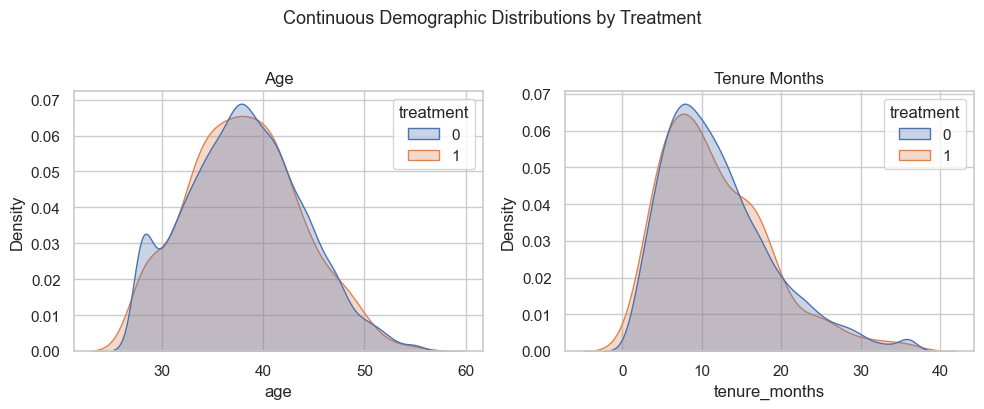

C:\Users\U1008500\AppData\Local\Temp\ipykernel_27596\3415765868.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\U1008500\AppData\Local\Temp\ipykernel_27596\3415765868.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


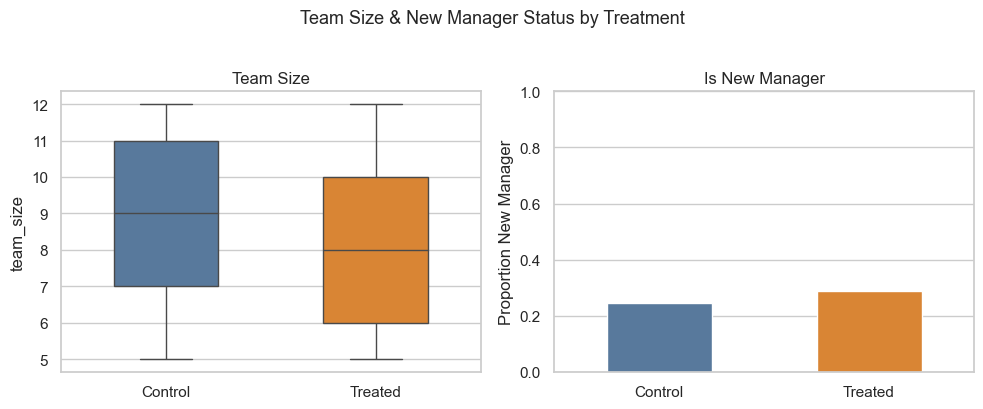

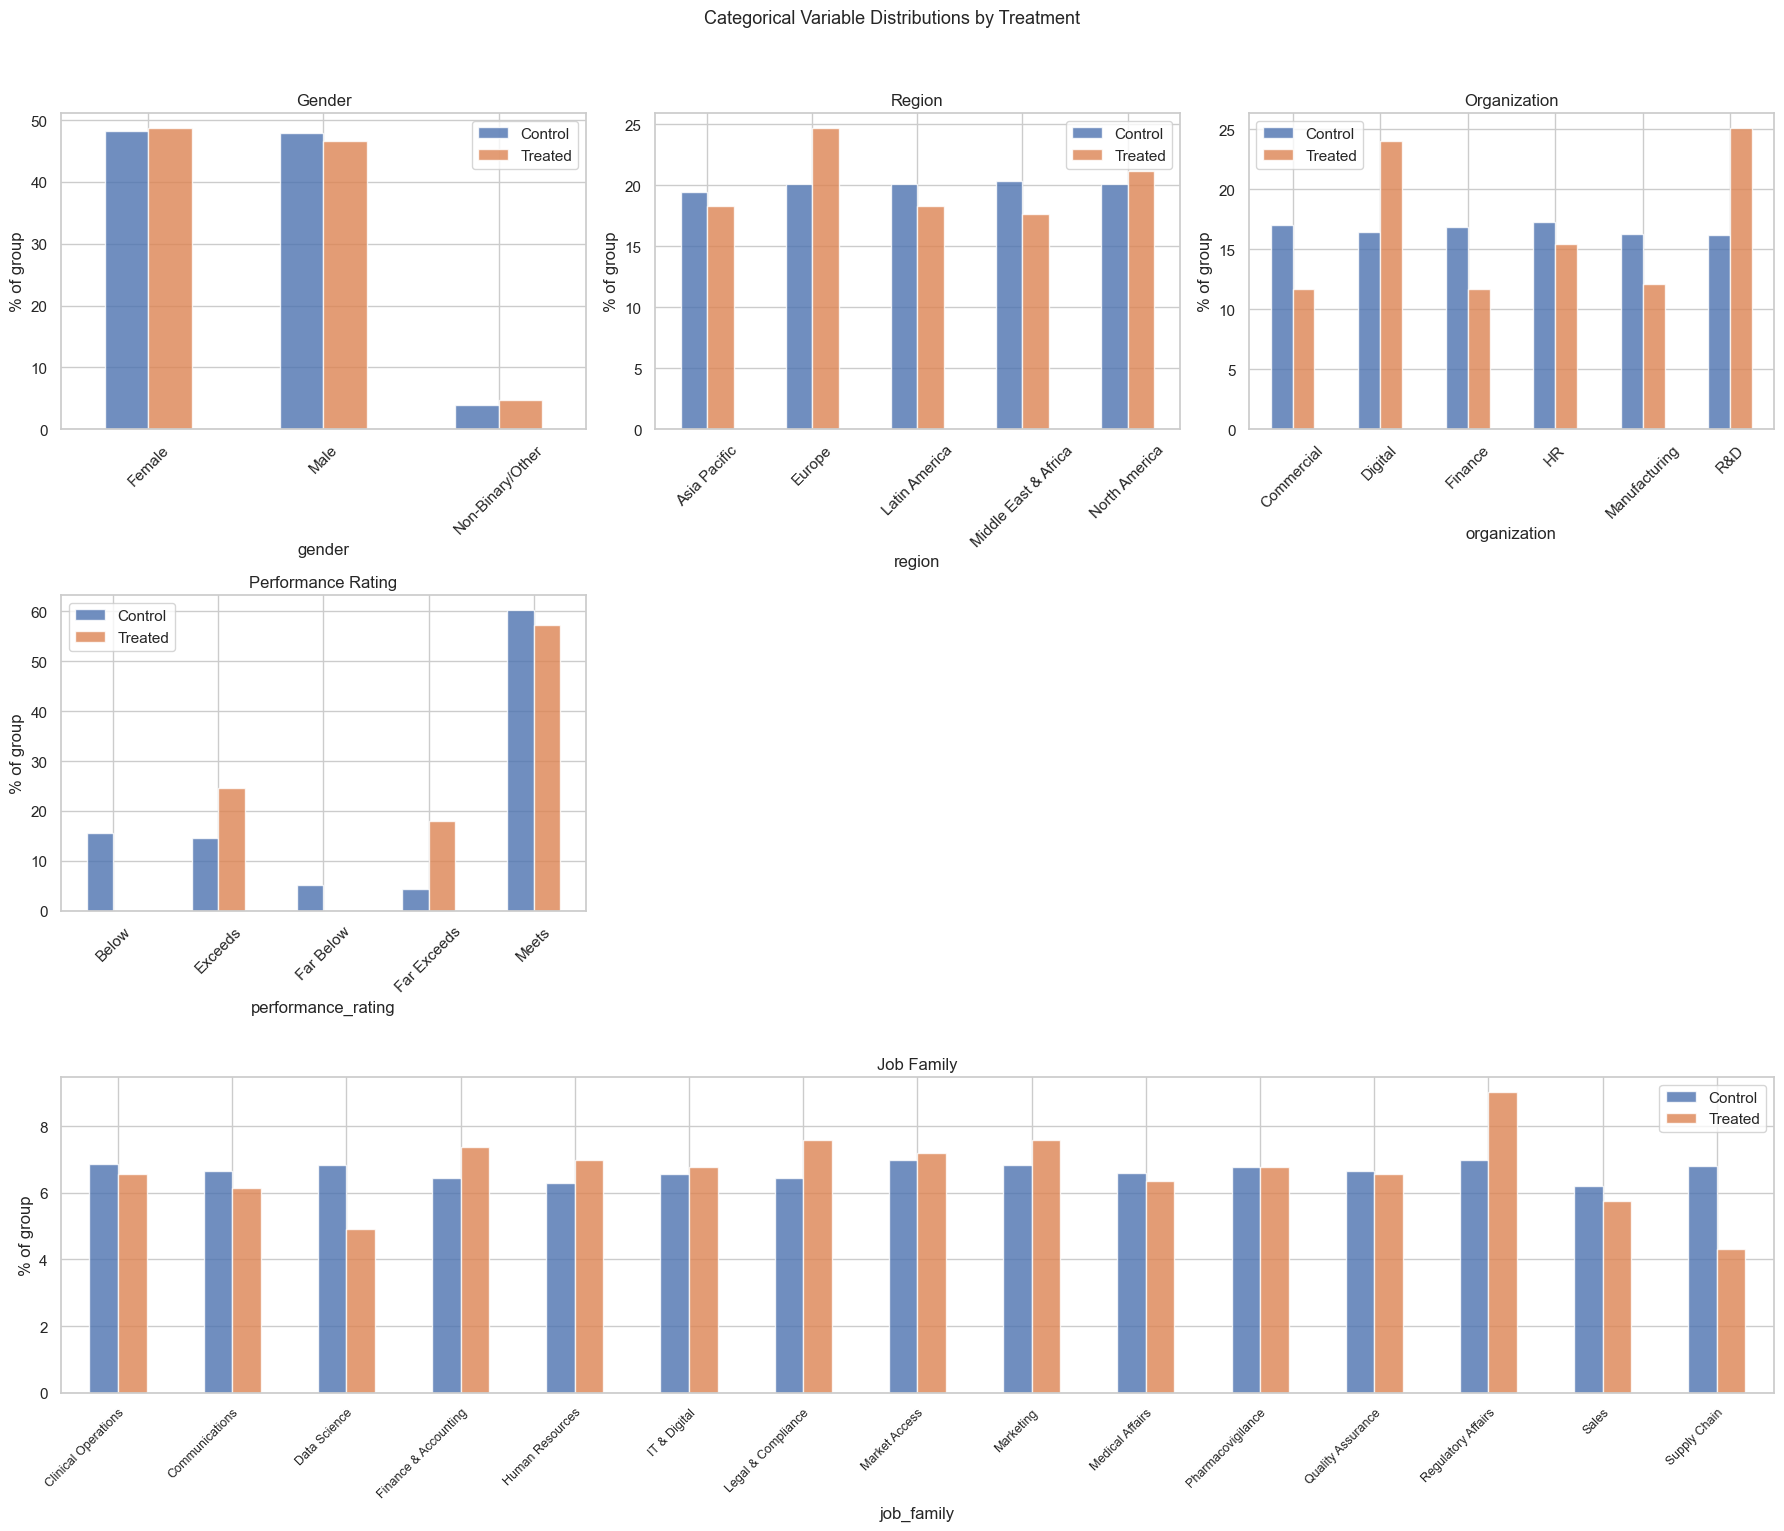

In [3]:
# =============================================================================
# DESCRIPTIVE EXPLORATION
# =============================================================================
# Compare outcomes for treated vs control, and explore potential confounders

# --- 1. Outcome columns ---
continuous_outcomes = [
    c for c in ["manager_efficacy_index", "workload_index_mgr", "turnover_intention_index_mgr"]
    if c in manager_df.columns
]
binary_outcomes = [
    c for c in ["retention_3month", "retention_6month", "retention_9month", "retention_12month"]
    if c in manager_df.columns
]
baseline_cols = [
    c for c in ["baseline_manager_efficacy", "baseline_workload",
                "baseline_turnover_intention", "baseline_manager_support"]
    if c in manager_df.columns
]

# --- 2. Demographic / covariate comparison ---
demo_continuous = [c for c in ["age", "tenure_months"] if c in manager_df.columns]
demo_num = demo_continuous + [c for c in ["team_size", "is_new_manager"] if c in manager_df.columns]
demo_cat = [c for c in ["gender", "region", "organization", "job_family", "performance_rating"] if c in manager_df.columns]

print("=" * 60)
print("DEMOGRAPHIC COMPARISON: Treated vs Control")
print("=" * 60)

# Continuous demographics: means
if demo_num:
    demo_means = manager_df.groupby("treatment")[demo_num].mean().T
    demo_means.columns = ["Control", "Treated"]
    demo_means["Diff (T - C)"] = demo_means["Treated"] - demo_means["Control"]
    display(demo_means.round(3))

# Categorical demographics: proportions
if demo_cat:
    print("\n" + "-" * 60)
    for col in demo_cat:
        ct = pd.crosstab(manager_df[col], manager_df["treatment"])
        ct.columns = ["Control", "Treated"]

        # Proportions within each group
        ct_pct = ct.div(ct.sum(axis=0), axis=1) * 100
        ct_pct.columns = ["Control %", "Treated %"]
        ct_pct["Diff (pp)"] = ct_pct["Treated %"] - ct_pct["Control %"]

        display(ct_pct.round(1))

# Visualise demographic distributions
# Row 1: KDE for truly continuous vars (age, tenure)
n_cont = len(demo_continuous)
if n_cont:
    fig, axes = plt.subplots(1, n_cont, figsize=(5 * n_cont, 4))
    if n_cont == 1:
        axes = [axes]
    for ax, col in zip(axes, demo_continuous):
        sns.kdeplot(
            data=manager_df, x=col, hue="treatment",
            common_norm=False, fill=True, alpha=0.3, ax=ax,
        )
        ax.set_title(col.replace("_", " ").title())
    plt.suptitle("Continuous Demographic Distributions by Treatment", y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()

# Row 2: Box plot for team_size, bar plot for is_new_manager
special_plots = []
if "team_size" in manager_df.columns:
    special_plots.append("team_size")
if "is_new_manager" in manager_df.columns:
    special_plots.append("is_new_manager")

if special_plots:
    fig, axes = plt.subplots(1, len(special_plots), figsize=(5 * len(special_plots), 4))
    if len(special_plots) == 1:
        axes = [axes]
    plot_df_special = manager_df.copy()
    plot_df_special["treatment_label"] = plot_df_special["treatment"].map({0: "Control", 1: "Treated"})
    for ax, col in zip(axes, special_plots):
        if col == "team_size":
            sns.boxplot(
                data=plot_df_special, x="treatment_label", y=col, ax=ax,
                order=["Control", "Treated"],
                palette={"Control": "#4C78A8", "Treated": "#F58518"}, width=0.5,
            )
            ax.set_xlabel("")
            ax.set_title("Team Size")
        elif col == "is_new_manager":
            pct = (
                manager_df.groupby("treatment")[col]
                .mean()
                .reset_index()
                .replace({"treatment": {0: "Control", 1: "Treated"}})
            )
            sns.barplot(
                data=pct, x="treatment", y=col, ax=ax,
                palette=["#4C78A8", "#F58518"], width=0.5,
            )
            ax.set_ylabel("Proportion New Manager")
            ax.set_xlabel("")
            ax.set_title("Is New Manager")
            ax.set_ylim(0, 1)
    plt.suptitle("Team Size & New Manager Status by Treatment", y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()

# Stacked bar charts for categorical variables
n_cat = len(demo_cat)
if n_cat:
    # Separate job_family from the rest
    other_cats = [col for col in demo_cat if col != "job_family"]
    n_other = len(other_cats)
    
    n_cols = 3
    n_rows = math.ceil(min(n_other, 6) / n_cols)
    
    # Create figure with GridSpec: regular rows + 1 wide row for job_family
    fig = plt.figure(figsize=(18, 5 * (n_rows + 1)))
    gs = GridSpec(n_rows + 1, n_cols, height_ratios=[1] * n_rows + [1])
    
    # Plot other categorical variables in the top rows
    for i, col in enumerate(other_cats[:n_rows * n_cols]):
        ax = fig.add_subplot(gs[i // n_cols, i % n_cols])
        ct_pct = pd.crosstab(manager_df[col], manager_df["treatment"], normalize="columns") * 100
        ct_pct.columns = ["Control", "Treated"]
        ct_pct.plot(kind="bar", ax=ax, alpha=0.8)
        ax.set_title(col.replace("_", " ").title())
        ax.set_ylabel("% of group")
        ax.legend(title="")
        ax.tick_params(axis="x", rotation=45)
    
    # Plot job_family on its own full-width row at the bottom
    if "job_family" in demo_cat:
        ax_job = fig.add_subplot(gs[n_rows, :])  # span all columns
        ct_pct = pd.crosstab(manager_df["job_family"], manager_df["treatment"], normalize="columns") * 100
        ct_pct.columns = ["Control", "Treated"]
        ct_pct.plot(kind="bar", ax=ax_job, alpha=0.8)
        ax_job.set_title("Job Family")
        ax_job.set_ylabel("% of group")
        ax_job.legend(title="")
        ax_job.tick_params(axis="x", rotation=45, labelsize=9)
        ax_job.set_xticklabels(ax_job.get_xticklabels(), ha="right", rotation_mode="anchor")
    
    plt.suptitle("Categorical Variable Distributions by Treatment", y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()

### Exploration Key Takeaways:
1. Some imbalance between Treatment and Control for: Job Family, Organization, and Region. Control teams trends slightly larger.
2. Problematic imbalance for performance: no low performing managers signed up for training.


DEMOGRAPHIC COMPARISON: Treated vs Control


,Control,Treated,Diff (T - C)
age,38.143,38.035,-0.108
tenure_months,11.973,11.723,-0.250
team_size,8.536,8.431,-0.105
is_new_manager,0.245,0.287,0.043



------------------------------------------------------------


,Control %,Treated %,Diff (pp)
gender,,,
Female,48.4,48.7,0.3
Male,47.8,46.6,-1.2
Non-Binary/Other,3.8,4.7,0.9


,Control %,Treated %,Diff (pp)
region,,,
Asia Pacific,19.5,18.3,-1.2
Europe,20.2,24.6,4.5
Latin America,19.9,18.3,-1.6
Middle East & Africa,20.2,17.7,-2.6
North America,20.2,21.1,0.9


,Control %,Treated %,Diff (pp)
organization,,,
Commercial,17.3,11.7,-5.6
Digital,16.1,24.0,7.9
Finance,16.7,11.7,-5.0
HR,17.4,15.4,-2.0
Manufacturing,16.6,12.1,-4.5
R&D,15.9,25.1,9.2


,Control %,Treated %,Diff (pp)
job_family,,,
Clinical Operations,6.7,6.6,-0.2
Communications,6.4,6.2,-0.2
Data Science,6.7,4.9,-1.7
Finance & Accounting,6.5,7.4,0.9
Human Resources,6.4,7.0,0.6
IT & Digital,6.6,6.8,0.2
Legal & Compliance,6.5,7.6,1.1
Market Access,7.1,7.2,0.1
Marketing,6.8,7.6,0.8


,Control %,Treated %,Diff (pp)
performance_rating,,,
Exceeds,18.4,24.6,6.3
Far Exceeds,5.5,18.1,12.6
Meets,76.2,57.3,-18.9


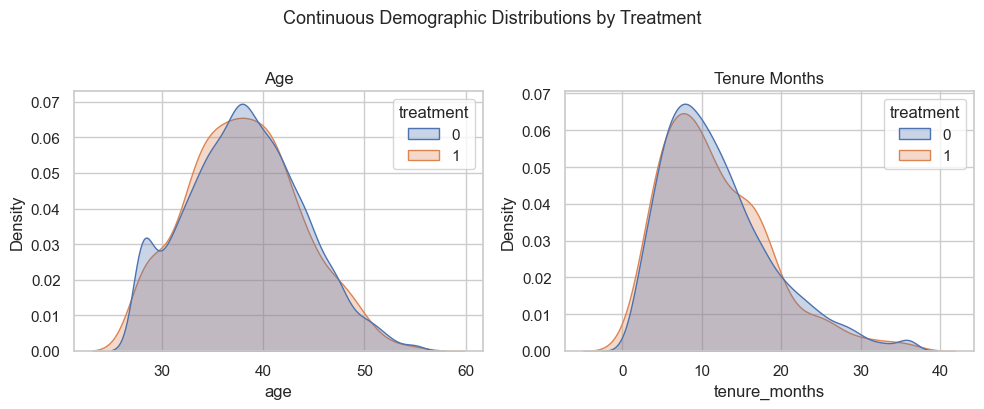

C:\Users\U1008500\AppData\Local\Temp\ipykernel_27596\577184744.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\U1008500\AppData\Local\Temp\ipykernel_27596\577184744.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


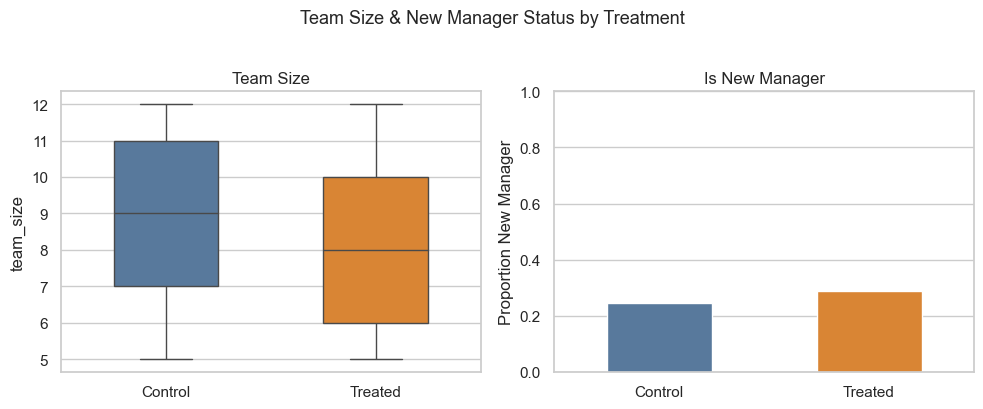

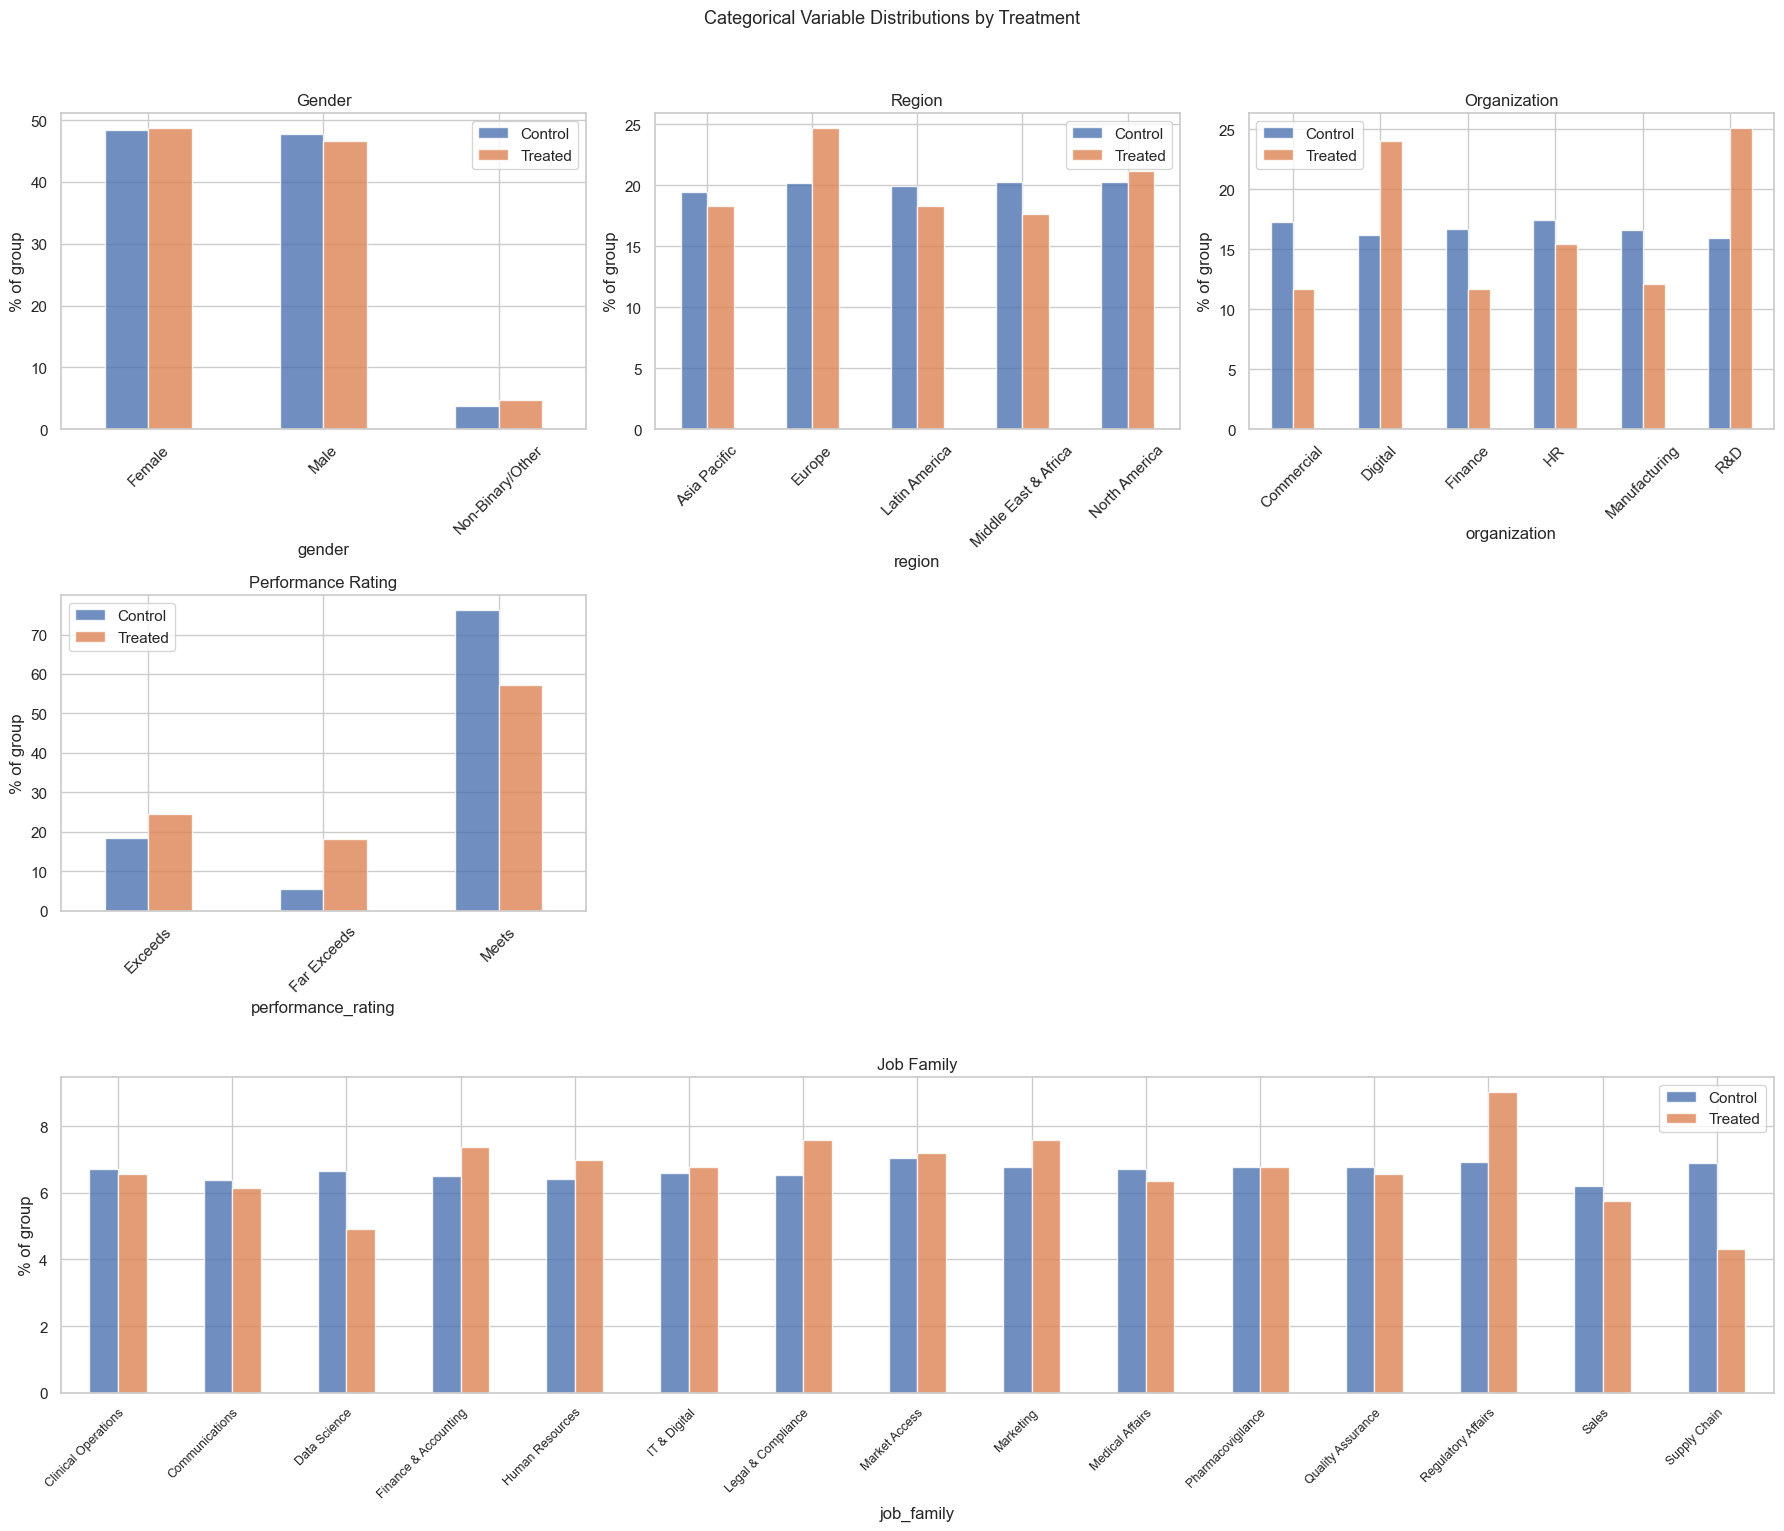

In [4]:
# Next Step:
# - Conduct statistical diagnostics for covariate overlap between treatment and control to get precise understanding of the severity of these imbalances.
# - Use diagnostics to determine appropriate method for estimating treatment effect.

#However, we know we will never achieve balance for performance rating because low performance did not participate. We have no way to extrapoluate effect for them.
#So, prior to running covariate balance, we will proactively exclude low performers. We will transparently report this decision and call out limitations in interpretation of the results.
#Ex. We cannot determine if this is an effective programe to intervene for low performers since they did not participate in the program. We can only determine if it is effective for mid/high performers. 

#remove performance_rating = Far Below or Below
manager_df_filtered = manager_df[~manager_df["performance_rating"].isin(["Far Below", "Below"])].copy().reset_index(drop=True)
#rerun descriptives
# =============================================================================
# DESCRIPTIVE EXPLORATION
# =============================================================================
# Compare outcomes for treated vs control, and explore potential confounders

# --- 1. Outcome columns ---
continuous_outcomes = [
    c for c in ["manager_efficacy_index", "workload_index_mgr", "turnover_intention_index_mgr"]
    if c in manager_df_filtered.columns
]
binary_outcomes = [
    c for c in ["retention_3month", "retention_6month", "retention_9month", "retention_12month"]
    if c in manager_df_filtered.columns
]
baseline_cols = [
    c for c in ["baseline_manager_efficacy", "baseline_workload",
                "baseline_turnover_intention", "baseline_manager_support"]
    if c in manager_df_filtered.columns
]

# --- 2. Demographic / covariate comparison ---
demo_continuous = [c for c in ["age", "tenure_months"] if c in manager_df_filtered.columns]
demo_num = demo_continuous + [c for c in ["team_size", "is_new_manager"] if c in manager_df_filtered.columns]
demo_cat = [c for c in ["gender", "region", "organization", "job_family", "performance_rating"] if c in manager_df_filtered.columns]

print("=" * 60)
print("DEMOGRAPHIC COMPARISON: Treated vs Control")
print("=" * 60)

# Continuous demographics: means
if demo_num:
    demo_means = manager_df_filtered.groupby("treatment")[demo_num].mean().T
    demo_means.columns = ["Control", "Treated"]
    demo_means["Diff (T - C)"] = demo_means["Treated"] - demo_means["Control"]
    display(demo_means.round(3))

# Categorical demographics: proportions
if demo_cat:
    print("\n" + "-" * 60)
    for col in demo_cat:
        ct = pd.crosstab(manager_df_filtered[col], manager_df_filtered["treatment"])
        ct.columns = ["Control", "Treated"]

        # Proportions within each group
        ct_pct = ct.div(ct.sum(axis=0), axis=1) * 100
        ct_pct.columns = ["Control %", "Treated %"]
        ct_pct["Diff (pp)"] = ct_pct["Treated %"] - ct_pct["Control %"]

        display(ct_pct.round(1))

# Visualise demographic distributions
# Row 1: KDE for truly continuous vars (age, tenure)
n_cont = len(demo_continuous)
if n_cont:
    fig, axes = plt.subplots(1, n_cont, figsize=(5 * n_cont, 4))
    if n_cont == 1:
        axes = [axes]
    for ax, col in zip(axes, demo_continuous):
        sns.kdeplot(
            data=manager_df_filtered, x=col, hue="treatment",
            common_norm=False, fill=True, alpha=0.3, ax=ax,
        )
        ax.set_title(col.replace("_", " ").title())
    plt.suptitle("Continuous Demographic Distributions by Treatment", y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()

# Row 2: Box plot for team_size, bar plot for is_new_manager
special_plots = []
if "team_size" in manager_df_filtered.columns:
    special_plots.append("team_size")
if "is_new_manager" in manager_df_filtered.columns:
    special_plots.append("is_new_manager")

if special_plots:
    fig, axes = plt.subplots(1, len(special_plots), figsize=(5 * len(special_plots), 4))
    if len(special_plots) == 1:
        axes = [axes]
    plot_df_special = manager_df_filtered.copy()
    plot_df_special["treatment_label"] = plot_df_special["treatment"].map({0: "Control", 1: "Treated"})
    for ax, col in zip(axes, special_plots):
        if col == "team_size":
            sns.boxplot(
                data=plot_df_special, x="treatment_label", y=col, ax=ax,
                order=["Control", "Treated"],
                palette={"Control": "#4C78A8", "Treated": "#F58518"}, width=0.5,
            )
            ax.set_xlabel("")
            ax.set_title("Team Size")
        elif col == "is_new_manager":
            pct = (
                manager_df_filtered.groupby("treatment")[col]
                .mean()
                .reset_index()
                .replace({"treatment": {0: "Control", 1: "Treated"}})
            )
            sns.barplot(
                data=pct, x="treatment", y=col, ax=ax,
                palette=["#4C78A8", "#F58518"], width=0.5,
            )
            ax.set_ylabel("Proportion New Manager")
            ax.set_xlabel("")
            ax.set_title("Is New Manager")
            ax.set_ylim(0, 1)
    plt.suptitle("Team Size & New Manager Status by Treatment", y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()

# Stacked bar charts for categorical variables
n_cat = len(demo_cat)
if n_cat:
    # Separate job_family from the rest
    other_cats = [col for col in demo_cat if col != "job_family"]
    n_other = len(other_cats)
    
    n_cols = 3
    n_rows = math.ceil(min(n_other, 6) / n_cols)
    
    # Create figure with GridSpec: regular rows + 1 wide row for job_family
    fig = plt.figure(figsize=(18, 5 * (n_rows + 1)))
    gs = GridSpec(n_rows + 1, n_cols, height_ratios=[1] * n_rows + [1])
    
    # Plot other categorical variables in the top rows
    for i, col in enumerate(other_cats[:n_rows * n_cols]):
        ax = fig.add_subplot(gs[i // n_cols, i % n_cols])
        ct_pct = pd.crosstab(manager_df_filtered[col], manager_df_filtered["treatment"], normalize="columns") * 100
        ct_pct.columns = ["Control", "Treated"]
        ct_pct.plot(kind="bar", ax=ax, alpha=0.8)
        ax.set_title(col.replace("_", " ").title())
        ax.set_ylabel("% of group")
        ax.legend(title="")
        ax.tick_params(axis="x", rotation=45)
    
    # Plot job_family on its own full-width row at the bottom
    if "job_family" in demo_cat:
        ax_job = fig.add_subplot(gs[n_rows, :])  # span all columns
        ct_pct = pd.crosstab(manager_df_filtered["job_family"], manager_df_filtered["treatment"], normalize="columns") * 100
        ct_pct.columns = ["Control", "Treated"]
        ct_pct.plot(kind="bar", ax=ax_job, alpha=0.8)
        ax_job.set_title("Job Family")
        ax_job.set_ylabel("% of group")
        ax_job.legend(title="")
        ax_job.tick_params(axis="x", rotation=45, labelsize=9)
        ax_job.set_xticklabels(ax_job.get_xticklabels(), ha="right", rotation_mode="anchor")
    
    plt.suptitle("Categorical Variable Distributions by Treatment", y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()

---

## Causal Identification Strategy

### Decision Flow

```mermaid
flowchart TB
    START2((("Scenario 2:<br/>Open Enrollment")))
    
    START2 --> S2
    S2["🎯 <b>Context</b><br/>500 managers self-selected<br/>vs 8,500 non-participants"]
    
    S2 -->|"Step 1: Assignment"| A2
    A2["⚠️ <b>SELF-SELECTION</b><br/>Voluntary participation<br/>Uneven departmental promotion"]
    
    A2 -->|"Step 2: Covariate Overlap"| COV2
    COV2{"🔍 <b>EVALUATE OVERLAP</b><br/>Check balance on:<br/>Demographics, Dept, Performance"}
    
    COV2 -->|"Propensity scores<br/>well-distributed"| MOD["Moderate<br/>Imbalance"]
    COV2 -->|"Extreme scores,<br/>sparse overlap"| SEV["Severe<br/>Imbalance"]
    
    MOD -->|"Step 3: Estimand"| EST2A
    EST2A["📊 <b>ATE</b><br/>Population-level effect<br/>Reweight to target population"]
    
    SEV -->|"Step 3: Estimand"| EST2B
    EST2B["📊 <b>ATT</b><br/>Effect on the treated only<br/>Safer when overlap is poor"]
    
    EST2A -->|"Step 4: Method"| METHOD2A
    METHOD2A["🔧 <b>IPTW + GEE</b><br/>• Stabilized propensity weights<br/>• Doubly robust: add covariates<br/>• Accounts for team clustering"]
    
    EST2B -->|"Step 4: Method"| METHOD2B
    METHOD2B["🔧 <b>Prognostic Score</b><br/>• Train model on controls only<br/>• t-test on residuals (Y - Ŷ)<br/>• Doubly robust: add covariates"]

    style START2 fill:#f57c00,stroke:#e65100,color:#fff
    style S2 fill:#ffe0b2,stroke:#ef6c00,color:#000
    style A2 fill:#ffccbc,stroke:#d84315,color:#000
    style COV2 fill:#fff9c4,stroke:#f9a825,color:#000
    style MOD fill:#dcedc8,stroke:#689f38,color:#000
    style SEV fill:#ffcdd2,stroke:#d32f2f,color:#000
    style EST2A fill:#d1c4e9,stroke:#512da8,color:#000
    style EST2B fill:#d1c4e9,stroke:#512da8,color:#000
    style METHOD2A fill:#b2dfdb,stroke:#00796b,color:#000
    style METHOD2B fill:#b2dfdb,stroke:#00796b,color:#000
```

| Step | Question | Answer  |
|------|----------|----------------------|
| 1 | How was treatment assigned? | ⚠️ **Self-selection** (voluntary participation) |
| 2 | Is there covariate imbalance? | 🔍 **Must diagnose** (check propensity scores, SMDs) |
| 3 | What estimand do we target? | 📊 **ATT** (severe) or **ATE** (moderate imbalance) |
| 4 | What method should we use? | 🔧 **Prognostic Score** or **IPTW + GEE** |

In [5]:
baselines = ['baseline_manager_efficacy', 'baseline_workload', 'baseline_turnover_intention']
#fill missing with 0
manager_df_filtered[baselines] = manager_df_filtered[baselines].fillna(0)
manager_df[baselines] = manager_df[baselines].fillna(0)

In [6]:
###############################################
# PRE-MODELING DIAGNOSTICS & COVARIATE OVERLAP
###############################################

# Document Variables for causal diagnostics
# Treatment variable
treatment = 'treatment'

# Outcome variables
outcome_vars = [
    'manager_efficacy_index',
    'workload_index_mgr',
    'turnover_intention_index_mgr',
    'retention_3month',
    'retention_6month',
    'retention_9month',
    'retention_12month'
]

# Baseline variables corresponding to each survey outcome
baseline_vars = {
    'manager_efficacy_index': 'baseline_manager_efficacy',
    'workload_index_mgr': 'baseline_workload',
    'turnover_intention_index_mgr': 'baseline_turnover_intention',
    'retention_3month': None,
    'retention_6month': None,
    'retention_9month': None,
    'retention_12month': None,
}

# Categorical covariates
categorical_vars = [
    'gender',
    'organization',
    'job_family',
    'performance_rating',
    'region'
]

# Binary covariates (0/1 flags)
binary_vars = [
    'is_new_manager'
]

# Continuous covariates
continuous_vars = [
    'age',
    'tenure_months',
    'team_size'
]

In [7]:
# Instantiate CausalDiagnostics and view help
cd = CausalDiagnostics()
cd.help()


        ╔══════════════════════════════════════════════════════════════════════════════╗
        ║  CausalDiagnostics — Unified Causal Inference Diagnostic Toolkit            ║
        ╚══════════════════════════════════════════════════════════════════════════════╝

        Usage:
            from supp_functions.causal_diagnostics import CausalDiagnostics
            cd = CausalDiagnostics()

        ────────────────────────────────────────────────────────────────────────────────
        GROUP A: PRE-MODELING DIAGNOSTICS
        ────────────────────────────────────────────────────────────────────────────────

        1. check_high_intercorrelations(df, numerical_threshold=0.7,
                                        categorical_threshold=0.7, verbose=False,
                                        exclude_vars=None)
        Detect highly correlated variable pairs using:
            • Pearson correlation     (numerical–numerical)
            • Cramér's V              (categorical–catego

In [8]:
# ===========================================================================================================================================
# PRE-MODELING DIAGNOSTICS 1: Multicollinearity
# 1. Intercorrelations: Linear relationship between two variables at a time
# 2. Variance Inflation Factor (VIF): How much a variable is explained by ALL other variables combined
# ==========================================================================================================================================

# Variables to exclude from pre-modeling checks (outcomes, IDs, treatment)
exclude_from_diagnostics = [
    'manager_id', 'treatment',
] + outcome_vars + [v for v in baseline_vars.values() if v is not None]

# --- Check 1: Intercorrelations ---
print("=" * 60)
print("CHECK 1: INTERCORRELATIONS")
print("=" * 60)
intercorr = cd.check_high_intercorrelations(
    manager_df_filtered,
    numerical_threshold=0.7,
    categorical_threshold=0.7,
    verbose=True,
    exclude_vars=exclude_from_diagnostics,
)
if not intercorr['all_high_correlation_pairs']:
    print("✅ No highly correlated pairs found.")
else:
    print(f"⚠️ Found {len(intercorr['all_high_correlation_pairs'])} highly correlated pair(s).")

# --- Check 2: Variance Inflation Factor (VIF) ---
print("\n" + "=" * 60)
print("CHECK 2: VARIANCE INFLATION FACTOR (VIF)")
print("=" * 60)
controls_for_vif = categorical_vars + binary_vars + continuous_vars
vif_results = cd.check_vif(
    manager_df_filtered,
    controls=controls_for_vif,
    treatment='treatment',
)
display(vif_results)

CHECK 1: INTERCORRELATIONS
✅ No highly correlated pairs found.

CHECK 2: VARIANCE INFLATION FACTOR (VIF)


,Variable,Type,VIF / GVIF,Adjusted (GVIF^1/2df),Shared Variance,Severity
0,tenure_months,Continuous,1.0809,1.0809,<25% of variance is shared,✅ None
1,is_new_manager,Continuous,1.0799,1.0799,<25% of variance is shared,✅ None
2,treatment,Continuous,1.0332,1.0332,<25% of variance is shared,✅ None
3,performance_rating,Categorical (2 dummies),1.0298,1.0074,<25% of variance is shared,✅ None
4,age,Continuous,1.0052,1.0052,<25% of variance is shared,✅ None
5,team_size,Continuous,1.0025,1.0025,<25% of variance is shared,✅ None
6,organization,Categorical (5 dummies),1.0249,1.0025,<25% of variance is shared,✅ None
7,gender,Categorical (2 dummies),1.0073,1.0018,<25% of variance is shared,✅ None
8,region,Categorical (4 dummies),1.0143,1.0018,<25% of variance is shared,✅ None
9,job_family,Categorical (14 dummies),1.0332,1.0012,<25% of variance is shared,✅ None


### Key Takeaways from Initial Diagnostics
- No major multi-collinearity concerns.

Next Step:
- Proceed with covariate overlap diagnostics.

---

## Key Diagnostic Questions

Before choosing between ATT and ATE:

Consider the research question...
What question are we trying to answer?
- ATE answers: 
    - "What is the average causal effect of the treatment across the entire population, regardless of whether they actually received the treatment?"
    - "Should we roll this out to everyone?"
- ATT answers: 
    - "What is the average causal effect of the treatment specifically for those who actually received the treatment?"
    - "Did this work for those who got it?"

Given the L&D teams motivation to impact as many managers as possible, ATE would be a useful estimation. But first, we need to ensure our data can elicit a defensible ATE estimand. We can do this by running the following diagnostics:
1. **Propensity Score Distribution**: Are scores clustered at extremes (0 or 1)?
2. **Common Support**: What proportion of treated units have comparable controls?
3. **Standardized Mean Differences**: Are any SMDs > 0.25 after weighting?
4. **Effective Sample Size**: Does IPTW drastically reduce effective N?

```mermaid
flowchart LR
    subgraph DIAG["Diagnostic Decision Guide"]
        D1["Check PS<br/>Distribution"] --> D2{"Extreme<br/>clustering?"}
        D2 -->|"Yes"| D3["→ Use ATT"]
        D2 -->|"No"| D4["Check<br/>SMDs"]
        D4 --> D5{"SMDs > 0.25<br/>after weighting?"}
        D5 -->|"Yes"| D3
        D5 -->|"No"| D6["→ May Use ATE"]
    end
    
    style D1 fill:#e3f2fd,stroke:#1976d2,color:#000
    style D2 fill:#fff9c4,stroke:#f9a825,color:#000
    style D3 fill:#ffcdd2,stroke:#d32f2f,color:#000
    style D4 fill:#e3f2fd,stroke:#1976d2,color:#000
    style D5 fill:#fff9c4,stroke:#f9a825,color:#000
    style D6 fill:#c8e6c9,stroke:#388e3c,color:#000
```

In [9]:
# ===========================================================================================================================================
# PRE-MODELING DIAGNOSTICS : IS CAUSAL COMPARISON CREDIBLE, AND WHAT ESTIMAND IS DEFENSIBLE?
# 1. Overlap Diagnostics: Do the treatment and control groups have sufficient overlap in covariate distributions? This includes:
#    a. Standardized Mean Differences (SMDs) for continuous variables (threshold <0.1)
#    b. Proportion differences for binary/categorical variables (threshold <0.1)
#    c. Visual diagnostics (e.g. density plots, box plots) to identify any extreme non-overlap
# 2. Based on the diagnostics, determine if the data supports a credible causal comparison between treated and control groups. If there are significant overlap issues, consider:
#    a. Restricting the sample to regions of common support (e.g. trimming or matching)
#    b. Changing the estimand to focus on the population where overlap exists (e.g. ATT instead of ATE)
# ==========================================================================================================================================

overlap_results = cd.run_overlap_diagnostics(
    data=manager_df_filtered,
    treatment_var=treatment,
    outcome_vars=outcome_vars,
    baseline_vars=baseline_vars,
    categorical_vars=categorical_vars,
    binary_vars=binary_vars,
    continuous_vars=continuous_vars,
)


STEP 2: OVERLAP / COMMON SUPPORT DIAGNOSTICS

    This step determines WHICH ESTIMAND (ATT vs ATE) is credible in your data.

    KEY CONCEPTS:
    - ATT (Average Treatment Effect on the Treated): Effect for those who got treatment
    → Requires: Good overlap for TREATED units (each treated has comparable controls)

    - ATE (Average Treatment Effect): Effect if we treated everyone
    → Requires: Good overlap BOTH directions (treated exist across control range too)

    With imbalanced samples, ATT is typically the credible estimand because
    many controls sit in regions where no treated units exist.

    We'll check overlap for each outcome (since adjustment sets include different baselines).
        
DETAILED DIAGNOSTICS
Checks 1A–1C (continuous, binary, categorical SMDs) are identical
across outcomes. Only baseline check (1D) and propensity-score model
(Check 2) vary by outcome due to outcome-specific baseline variables.
Showing full detail for first outcome: manager_efficacy_

,Outcome,AUC,Treated Overlap %,Control Overlap %,Max |SMD| (Source),Baseline Balance,Imbalanced Vars,Estimand,Rationale
0,manager_efficacy_index,0.646,89.5,91.7,0.401 (performance_rating),✓ Good (0.082),performance_rating (0.40); organization (0.23)...,ATE,Strong bidirectional overlap; ATE fully defens...
1,workload_index_mgr,0.644,89.1,92.5,0.401 (performance_rating),✓ Good (0.002),performance_rating (0.40); organization (0.23)...,ATE,Strong bidirectional overlap; ATE fully defens...
2,turnover_intention_index_mgr,0.641,89.3,92.1,0.401 (performance_rating),✓ Good (0.041),performance_rating (0.40); organization (0.23)...,ATE,Strong bidirectional overlap; ATE fully defens...
3,retention_3month,0.647,88.3,91.0,0.401 (performance_rating),N/A (no baseline),performance_rating (0.40); organization (0.23)...,ATE,Strong bidirectional overlap; ATE fully defens...
4,retention_6month,0.647,88.3,91.0,0.401 (performance_rating),N/A (no baseline),performance_rating (0.40); organization (0.23)...,ATE,Strong bidirectional overlap; ATE fully defens...
5,retention_9month,0.647,88.3,91.0,0.401 (performance_rating),N/A (no baseline),performance_rating (0.40); organization (0.23)...,ATE,Strong bidirectional overlap; ATE fully defens...
6,retention_12month,0.647,88.3,91.0,0.401 (performance_rating),N/A (no baseline),performance_rating (0.40); organization (0.23)...,ATE,Strong bidirectional overlap; ATE fully defens...



INTERPRETATION GUIDE: WHAT THIS MEANS FOR YOUR ANALYSIS

    ╔══════════════════════════════════════════════════════════════════════════════╗
    ║  WHAT IS COVARIATE OVERLAP AND WHY DOES IT MATTER?                           ║
    ╠══════════════════════════════════════════════════════════════════════════════╣
    ║                                                                              ║
    ║  Causal inference requires COMPARABLE treatment and control groups.          ║
    ║  "Comparable" means: for each treated person, there exist control people     ║
    ║  with similar characteristics (covariates) who can serve as counterfactuals. ║
    ║                                                                              ║
    ║  If groups occupy DIFFERENT covariate spaces, we cannot observe what would   ║
    ║  have happened to treated people without treatment — we must EXTRAPOLATE.    ║
    ║                                                                              ║
    ║  

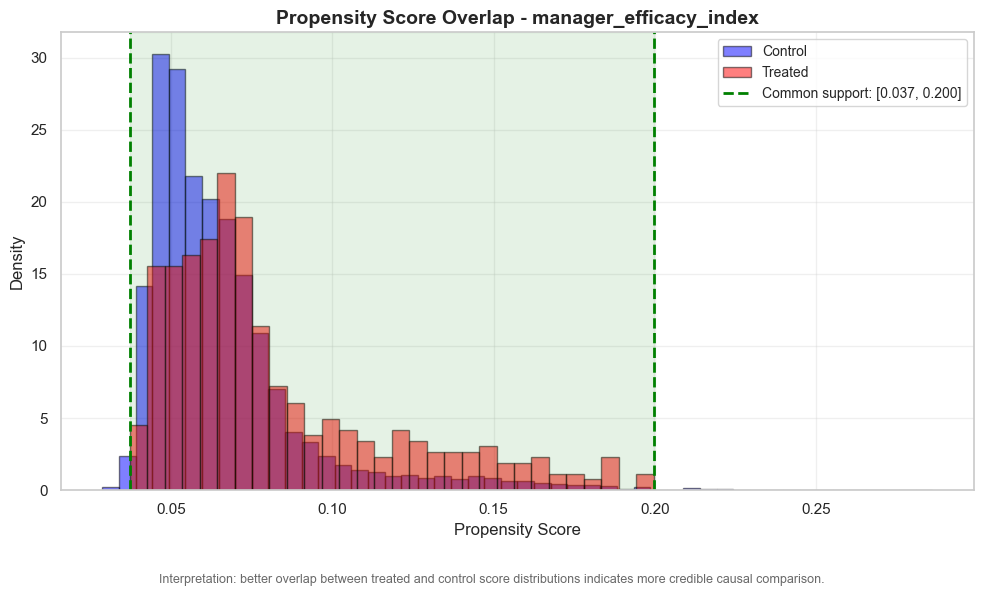

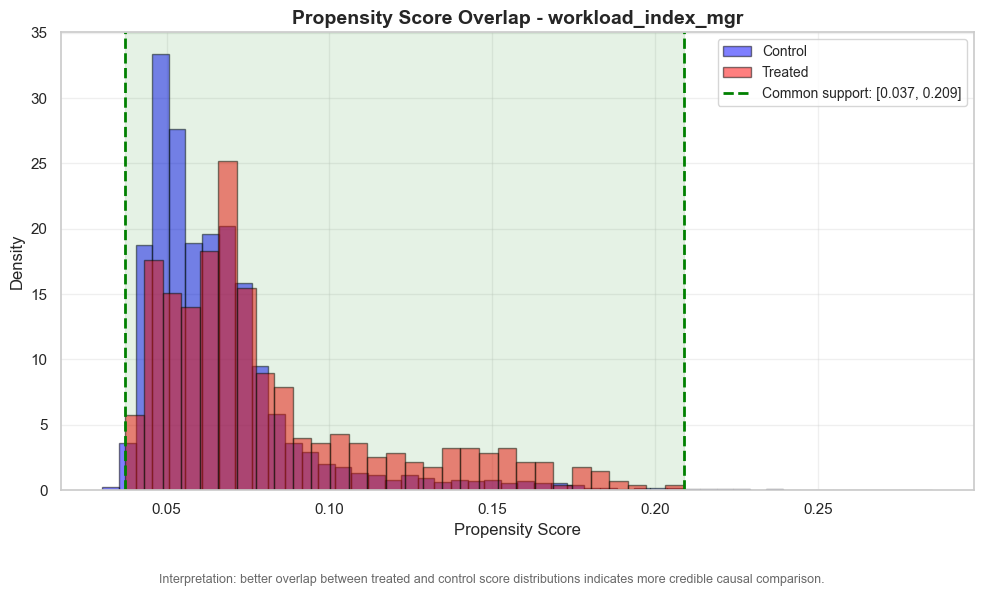

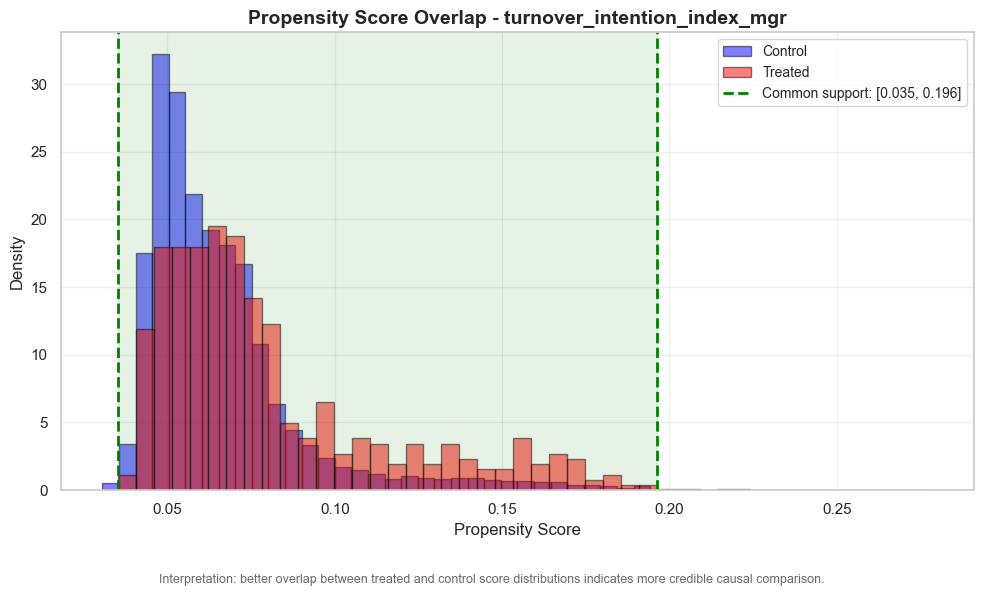

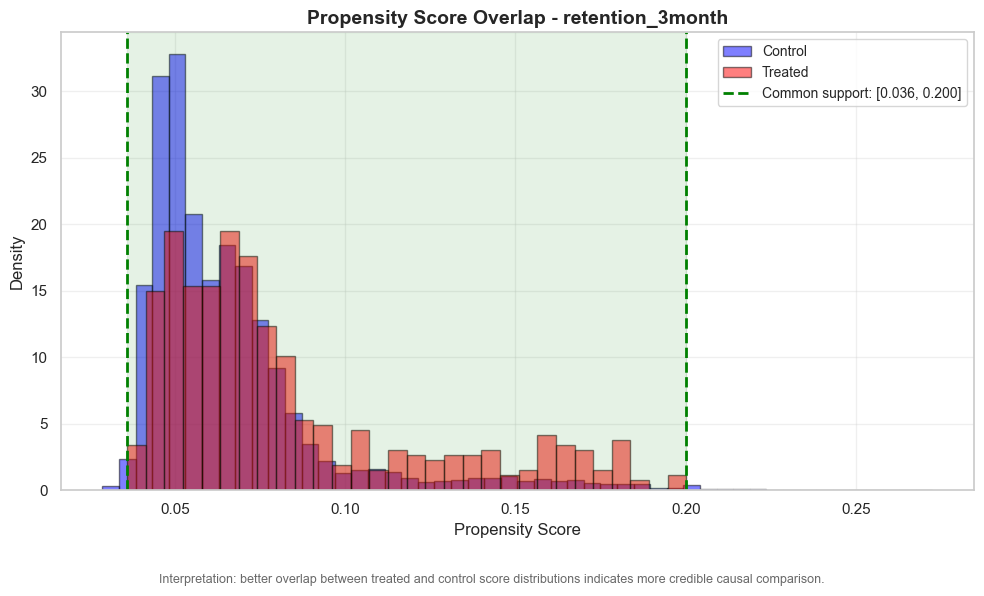

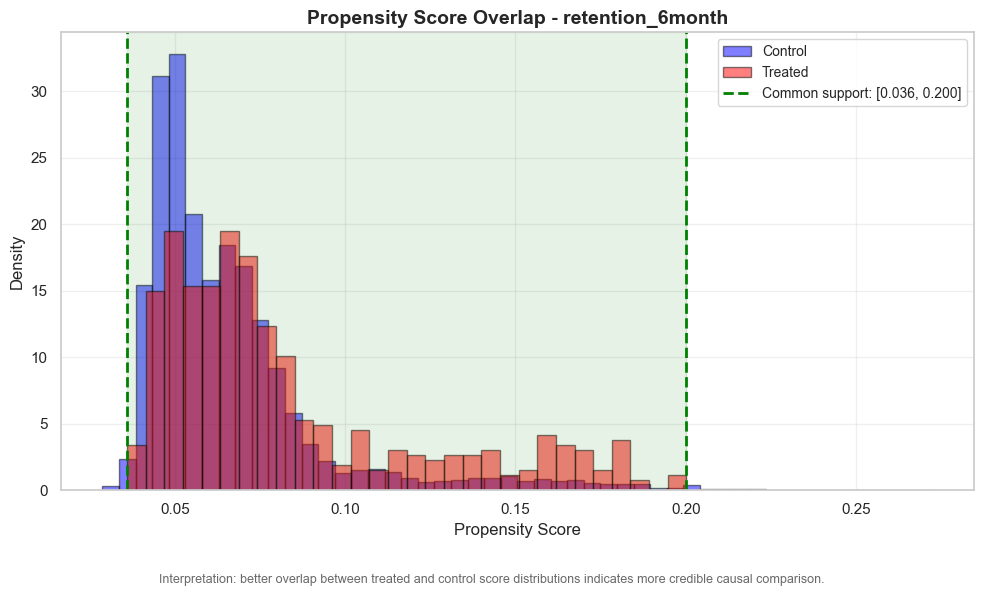

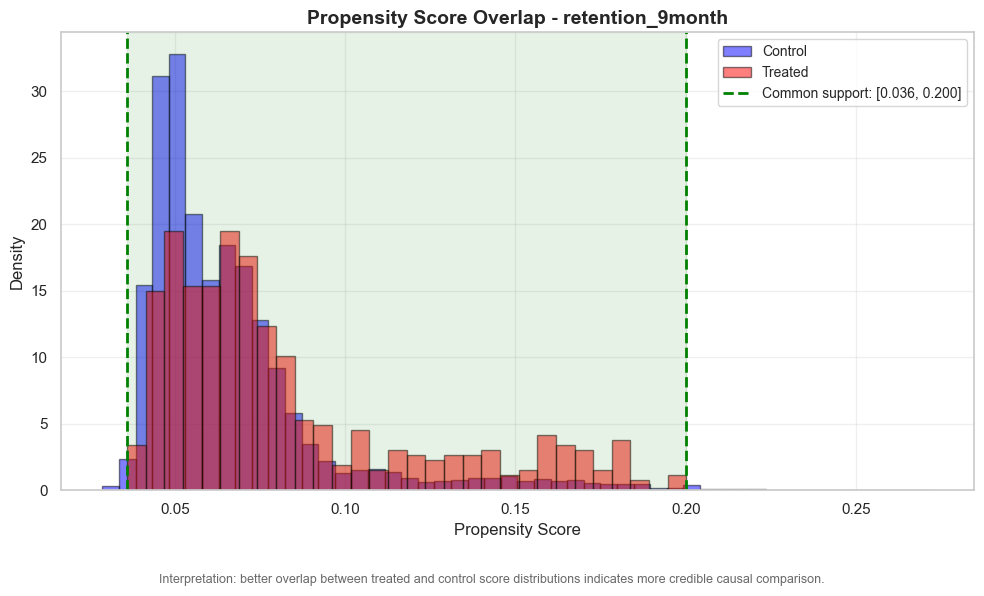

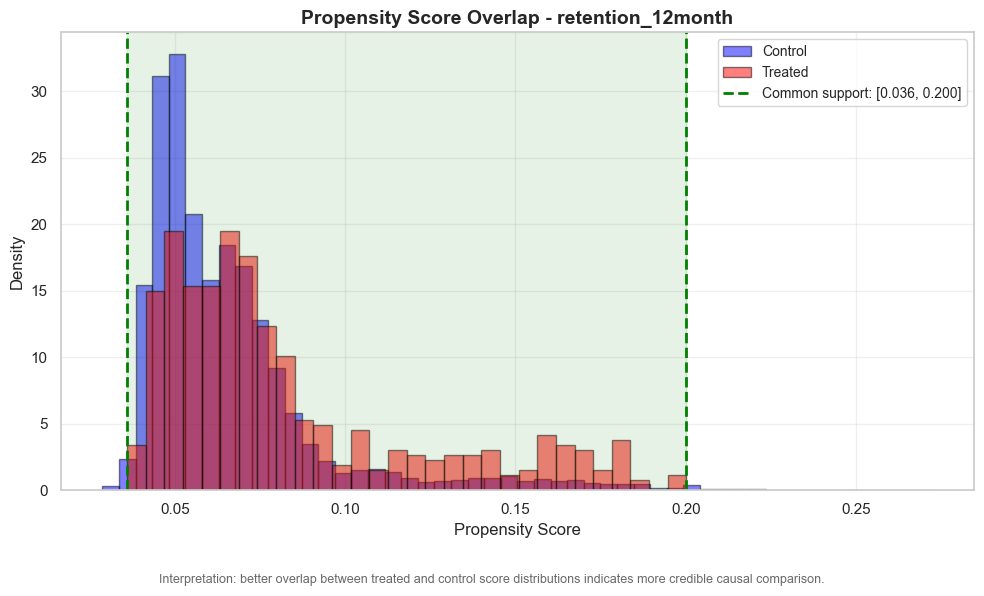

In [10]:
# =============================================================================
# Visualize propensity score overlap per outcome
# =============================================================================
for outcome_var in outcome_vars:
    result = overlap_results.get(outcome_var)
    if result is None:
        continue

    ps = result.get('propensity_scores')
    if ps is not None:
        cd.plot_propensity_overlap(
            data=manager_df_filtered,
            treatment_var=treatment,
            propensity_scores=ps,
            outcome_var=outcome_var,
        )

In [31]:
# =============================================================================
# Save overlap diagnostics summary
# =============================================================================
cd.save_overlap_diagnostics_summary(
    overlap_results,
    save_path=str(base_dir / "results/s2_overlap_diagnostics_summary.txt"),
)


✓ Diagnostics summary saved to: c:\Users\U1008500\OneDrive - Sanofi\Documents\GitHub\PeopleAnalytics-DataScience-adhoc-projects\2026_causal_inference_framework\results\s2_overlap_diagnostics_summary.txt


### Key Takeaways from Covariate Overlap Diagnostics
- After removing untreated controls (Low performers), all diagnostics suggest that we can reasonably estimate ATE.
- AUC is <0.7 and we see sufficient overlap of the treatment group in the control group, and vice versa (~90% for both overlap directions).
    - This indicates that treatment and control groups are similar to each other and treatment assignment is quasi-random. (Covariates cannot fully predict the outcome.)
- The data contains moderate imbalance across: region, remaining performance categories, organization, and job family. 
    - We will address this through Inverse Probability of Treatment Weighting (IPTW) with Generalized Estimating Equations (GEE)


Next Step:
- Proceed with ATE model specification and execution.

---

## Estimating Average Treatment Effect using IPTW + GEE (for Moderate Imbalance)

Use this approach when treatment is not purely randomized, propensity scores are well-distributed (good overlap), and weighted standardized mean differences (SMDs) are acceptable after weighting.

This approach estimates the **Average Treatment Effect (ATE)** using:

- Stabilized and trimmed inverse probability of treatment weights (IPTW)
- GEE to account for clustering (individuals nested within their direct manager's team)
- Robust (sandwich) standard errors
- Covariate adjustment in the outcome model for **doubly robust estimation**

> **Note on estimand:** GEE itself is agnostic to the estimand — it simply fits a weighted regression with cluster-robust standard errors. Whether you estimate the **ATE** or the **ATT** is determined entirely by how the weights are constructed. This implementation uses **ATE weights**, which reweight both treated and control groups to represent the full population.

---

Let:

- $Y_i$ = outcome for individual $i$
- $Treatment_i$ = 1 if individual $i$ participated, 0 otherwise
- $X_i$ = pre-treatment individual-level covariates
- $Team_i$ = the direct manager's team that individual $i$ belongs to (used for clustering)

The weighted GEE model is:

$$
g\big(E[Y_i]\big) =
\beta_0 + \beta_1 \cdot Treatment_i + \beta_2 \cdot X_i
$$

Where:

- $g(\cdot)$ is the link function (identity for continuous outcomes, logit for binary outcomes)
- Weights = **stabilized and trimmed ATE inverse probability weights**
- Propensity scores are estimated at the **individual level** — one score per person, reflecting the probability that an individual received treatment given their observed covariates: $\hat{e}_i = P(Treatment_i = 1 \mid X_i)$
- **ATE weights** are then constructed as:
  - Treated individuals: $w_i = 1 \;/\; \hat{e}_i$
  - Control individuals: $w_i = 1 \;/\; (1 - \hat{e}_i)$
  - This reweights **both** groups to represent the full population — upweighting individuals who were unlikely to receive the treatment they actually received
  - For comparison, **ATT weights** would leave treated individuals unweighted ($w_i = 1$) and reweight controls as $w_i = \hat{e}_i \;/\; (1 - \hat{e}_i)$ to match the treated group's covariate distribution. The choice of ATE vs. ATT is entirely determined by the weight formula, not by GEE.
- Weights are **stabilized** by multiplying by the marginal treatment probability:
  - Treated: $w_i^{stab} = \bar{p} \;/\; \hat{e}_i$
  - Control: $w_i^{stab} = (1 - \bar{p}) \;/\; (1 - \hat{e}_i)$
  - where $\bar{p}$ is the sample-average treatment probability. Stabilization reduces the range of weight values while preserving balance.
- Weights are **trimmed** by capping values above a specified quantile (e.g., 99th percentile). This reduces the influence of individuals with extreme propensity scores — those who were very unlikely to receive the treatment they actually received — which can otherwise destabilize estimates. Trimming introduces a small bias but substantially reduces variance.
- Clustering is specified at the **team level** (by direct manager ID) — individuals who share the same direct manager are grouped together. GEE sandwich standard errors account for the fact that teammates may have correlated outcomes due to shared work environment, leadership, and team dynamics.
- Note: GEE sandwich standard errors account for within-team correlation but do **not** propagate uncertainty from the first-stage propensity score estimation. For stricter inference, consider a non-parametric bootstrap that re-estimates both stages in each replicate.

---

### Continuous Outcome (Identity Link)

$$
E[Y_i] =
\beta_0 + \beta_1 \cdot Treatment_i + \beta_2 \cdot X_i
$$

- $\beta_1$ = **ATE**: the weighted average difference in outcomes between treated and control individuals, after reweighting to balance observed confounders
- Interpretation: on average across the population, treatment shifts the outcome by $\beta_1$ units

---

### Binary Outcome (Logit Link)

$$
\log\left(\frac{P(Y_i=1)}{1-P(Y_i=1)}\right)
=
\beta_0 + \beta_1 \cdot Treatment_i + \beta_2 \cdot X_i
$$

- $e^{\beta_1}$ = **population-averaged marginal odds ratio**: the odds of the outcome occurring for treated individuals relative to control individuals, averaged across the population
- Note: because GEE estimates population-averaged (marginal) effects rather than subject-specific effects, $e^{\beta_1}$ reflects the average odds ratio across all individuals, not the odds ratio for any particular person

---

## Doubly Robust Interpretation

The model is **doubly robust**: $\beta_1$ consistently estimates the ATE if **at least one** of the following holds:

- The propensity score model $P(Treatment_i = 1 \mid X_i)$ is correctly specified, **or**
- The outcome model (including $X_i$) is correctly specified

Both models being misspecified simultaneously will produce biased estimates. In practice, doubly robust estimation is most valuable as a safeguard — not a substitute for careful model specification in both stages.

Two additional assumptions are always required regardless of model correctness:

- **Positivity (overlap):** Every individual must have a non-zero probability of receiving either treatment or control given their covariates — i.e., $0 < P(Treatment_i = 1 \mid X_i) < 1$ for all $i$. Violations (propensity scores near 0 or 1) produce extreme weights and unstable estimates.
- **Correct temporal ordering:** All covariates $X_i$ must be measured **prior to** treatment assignment to qualify as true pre-treatment confounders. Including post-treatment variables as covariates can introduce bias.

---

## Summary: Model Design Choices

| Design Choice | Problem It Solves | Example | What It Does |
|---------------|-------------------|---------|--------------|
| **IPTW (Inverse Probability of Treatment Weighting)** | Treatment assignment is non-random; treated and control groups differ on observed confounders | Individuals who volunteered for training differ systematically from those who didn't (e.g., higher baseline performance, more tenure) | Reweights observations so treated and control groups have balanced covariate distributions, mimicking randomization. Upweights individuals who were unlikely to receive the treatment they got; downweights those who were likely to receive it. |
| **ATE Weights** | You want to estimate the effect of treatment across the **full population**, not just those who were treated | Deciding whether to mandate a program for all individuals | Reweights **both** treated and control groups to represent the full population. Treated: $w_i = 1/\hat{e}_i$, Control: $w_i = 1/(1-\hat{e}_i)$. Contrast with ATT weights, which leave treated unweighted and reweight controls to match the treated group. |
| **Stabilized Weights** | Extreme weights from rare propensity scores cause high variance and unstable estimates | An individual with PS = 0.02 gets weight = 1/0.02 = 50, dominating the analysis | Multiplies weights by the marginal treatment probability $\bar{p}$, reducing the range of weight values while preserving balance. Stabilized weights have mean ≈ 1 instead of highly variable. |
| **Weight Trimming** | A few individuals with extreme propensity scores (near 0 or 1) produce outlier weights that destabilize estimates | One person with PS = 0.001 gets weight = 1000, overwhelming all other observations | Caps weights at a specified quantile (e.g., 99th percentile). Introduces small bias but substantially reduces variance. Trades off some precision for stability. |
| **GEE Clustering** | Observations within groups (teams) are not independent; teammates share common shocks and environments | Individuals under the same manager have correlated outcomes due to shared leadership style, team culture, workload | Models within-cluster correlation structure and adjusts coefficient estimation accordingly. Produces population-averaged (marginal) effects rather than cluster-specific effects. Prevents underestimation of standard errors. |
| **Sandwich (Robust) Standard Errors** | Model assumptions about variance structure may be wrong (heteroskedasticity, misspecified correlation) | You assumed exchangeable correlation within teams, but the true correlation structure is more complex | Uses observed residuals to empirically estimate the true variance, producing standard errors that are valid even if variance assumptions are violated. Makes GEE robust to misspecification of the working correlation structure. |
| **Doubly Robust Estimation** | Uncertainty about whether propensity score model or outcome model is correctly specified | You're not sure if you've included all relevant confounders, or if the functional form of relationships is correct | Includes covariates in both the propensity score model (via weights) and the outcome model (via regression adjustment). ATE estimate is consistent if **either** model is correct — you get two chances instead of one. |
| **Propensity Score Clipping** | Division by propensity scores near 0 or 1 produces infinite or undefined weights | Propensity score = 0.0000001 → weight = 10,000,000 | Clips propensity scores to a safe range (e.g., [0.000001, 0.999999]) before calculating weights. Prevents numerical overflow and extreme weight values. |
| **Auto-Detection of Outcome Family** | Binary and continuous outcomes require different link functions and distributional assumptions | Retention (0/1) needs logit link; engagement score (1-5) needs identity link | Inspects unique values of the outcome variable. If only {0, 1}, uses Binomial family with logit link. Otherwise, uses Gaussian family with identity link. Ensures appropriate model specification. |
| **Multiple Testing Correction (FDR)** | Testing multiple outcomes inflates Type I error rate (false positives) | Testing 7 outcomes at α=0.05 gives ~30% chance of at least one false positive under the null | Applies Benjamini-Hochberg FDR correction across all p-values within an outcome family. Controls the expected proportion of false discoveries among rejected hypotheses. Applied **across outcomes**. |

In [22]:
#reload / import causal inference modeling class for IPTW-weighted GEE models (continuous and binary outcomes)
import importlib
import causal_inference_modelling
importlib.reload(causal_inference_modelling)
from causal_inference_modelling import IPTWGEEModel


ANALYZING OUTCOME: manager_efficacy_index


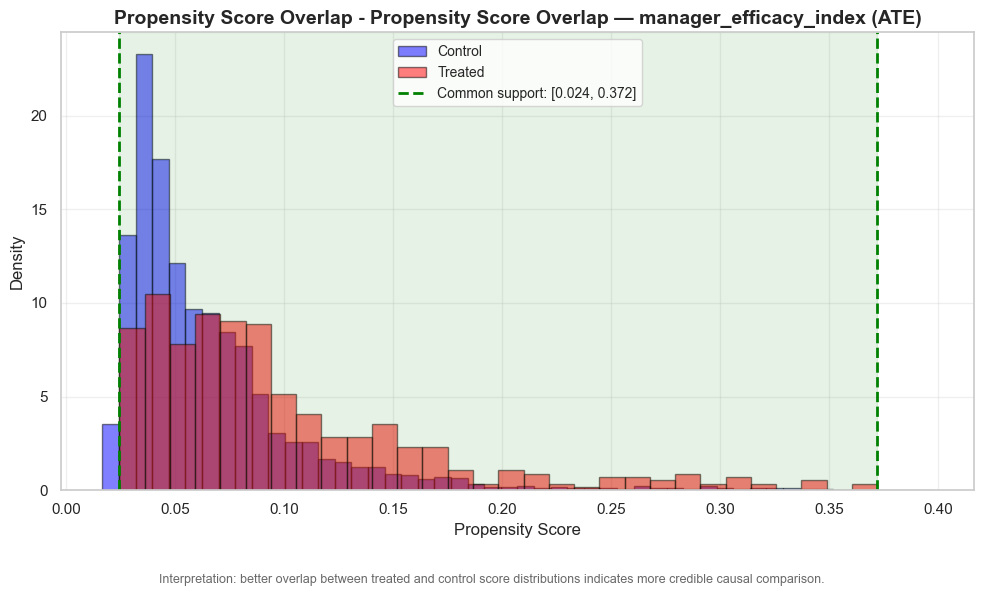

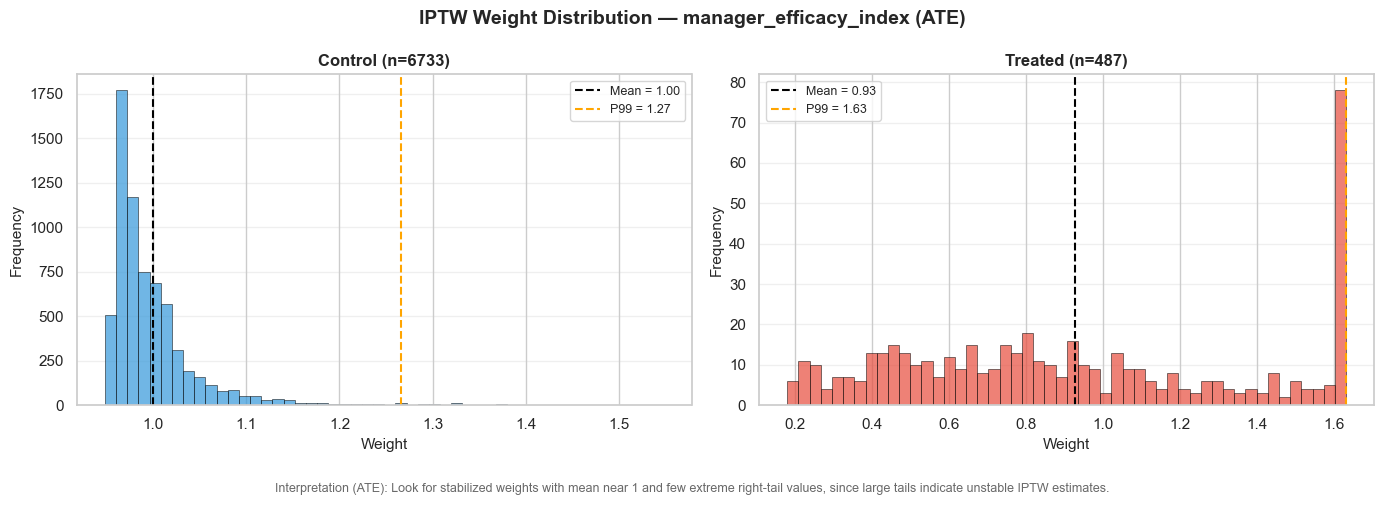

  [manager_efficacy_index] ATE = 0.4006 (95% CI: [0.3226, 0.4786]), p = 0.0000 ***, Cohen's d = 0.4789


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
28,treatment,0.400597,0.039814,0.322563,0.47863,8.150041e-24,0.05



ANALYZING OUTCOME: workload_index_mgr


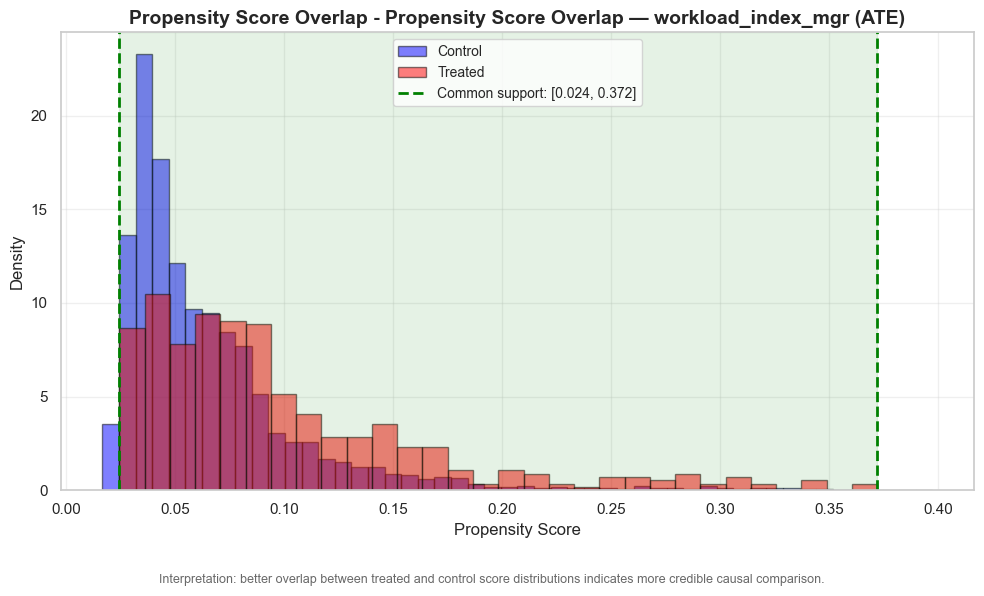

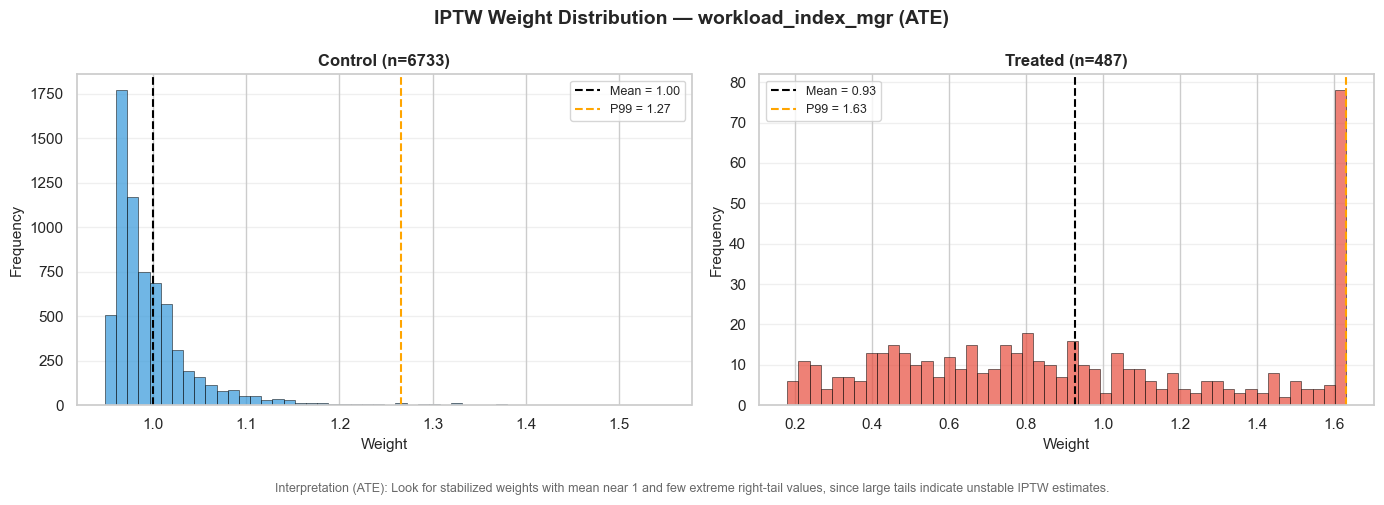

  [workload_index_mgr] ATE = -0.0408 (95% CI: [-0.1232, 0.0416]), p = 0.3316 , Cohen's d = -0.0593


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
28,treatment,-0.040809,0.042029,-0.123185,0.041567,0.331564,0.05



ANALYZING OUTCOME: turnover_intention_index_mgr


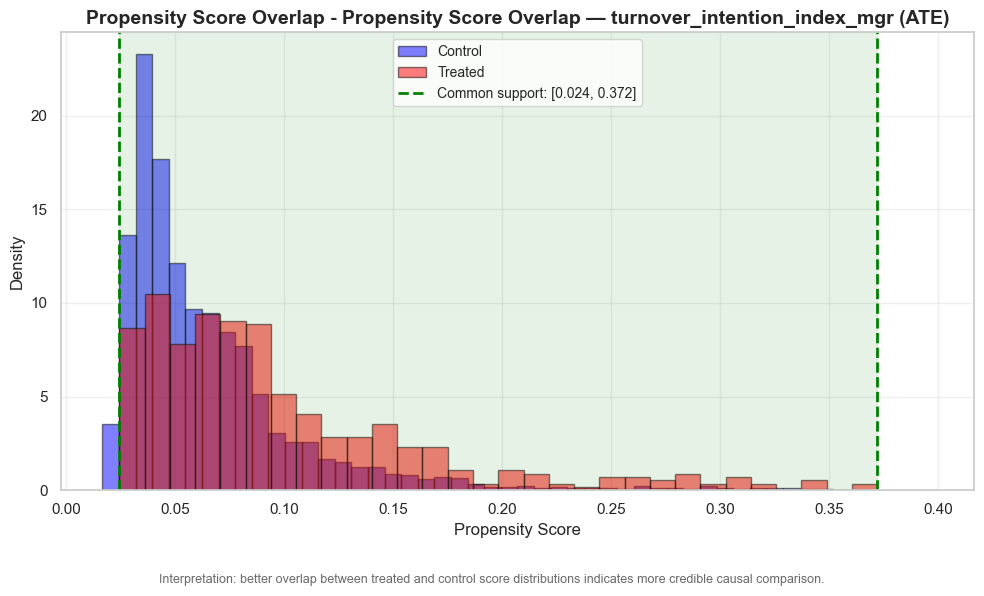

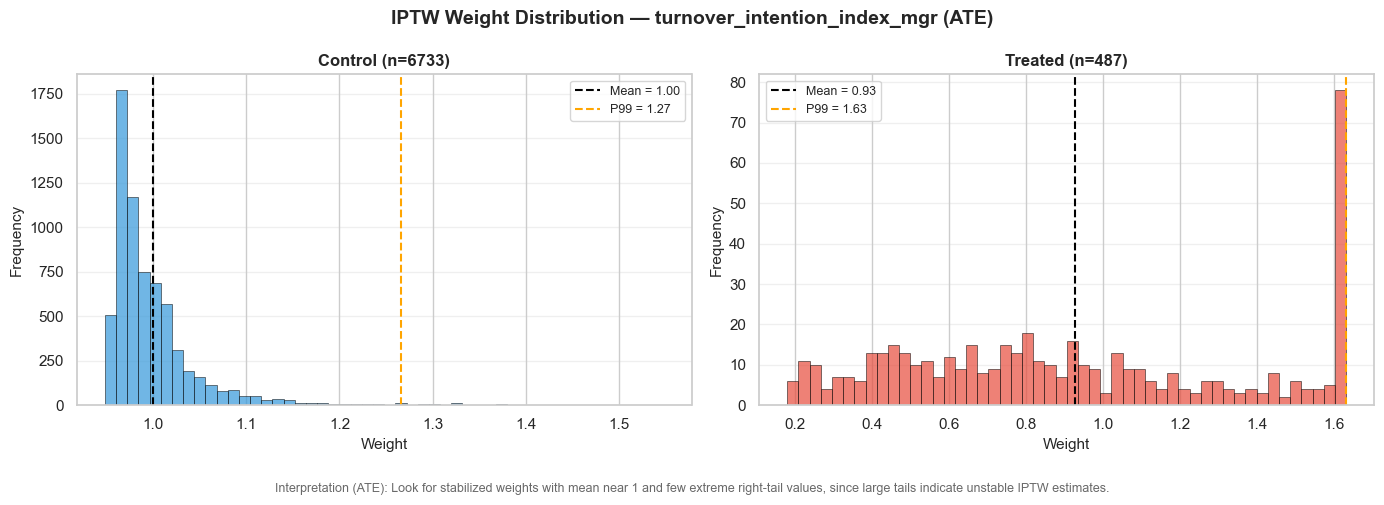

  [turnover_intention_index_mgr] ATE = 0.2312 (95% CI: [0.1467, 0.3156]), p = 0.0000 ***, Cohen's d = 0.2684


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
28,treatment,0.231165,0.043076,0.146738,0.315592,8.028324e-08,0.05



  IPTW + GEE: ATE Summary — Survey Outcomes (3 tests)
                     Outcome  Effect Estimand Std_Error CI_Lower CI_Upper P_Value Cohens_d Pct_Change Mean_Treatment Mean_Control    N    ESS P_Value_Corrected  Significant Significance Correction_Method
      manager_efficacy_index  0.4006      ATE    0.0398   0.3226   0.4786  0.0000   0.4789     11.97%         3.7873       3.3824 7220 7099.2            0.0000         True          ***            fdr_bh
          workload_index_mgr -0.0408      ATE    0.0420  -0.1232   0.0416  0.3316  -0.0593     -1.73%         3.1361       3.1914 7220 7099.2            0.3316        False                         fdr_bh
turnover_intention_index_mgr  0.2312      ATE    0.0431   0.1467   0.3156  0.0000   0.2684      9.11%         3.0523       2.7975 7220 7099.2            0.0000         True          ***            fdr_bh
  Significance: *** p<0.001, ** p<0.01, * p<0.05
  Correction: fdr_bh across 3 outcomes

  Summary table saved to c:\Users\U10085

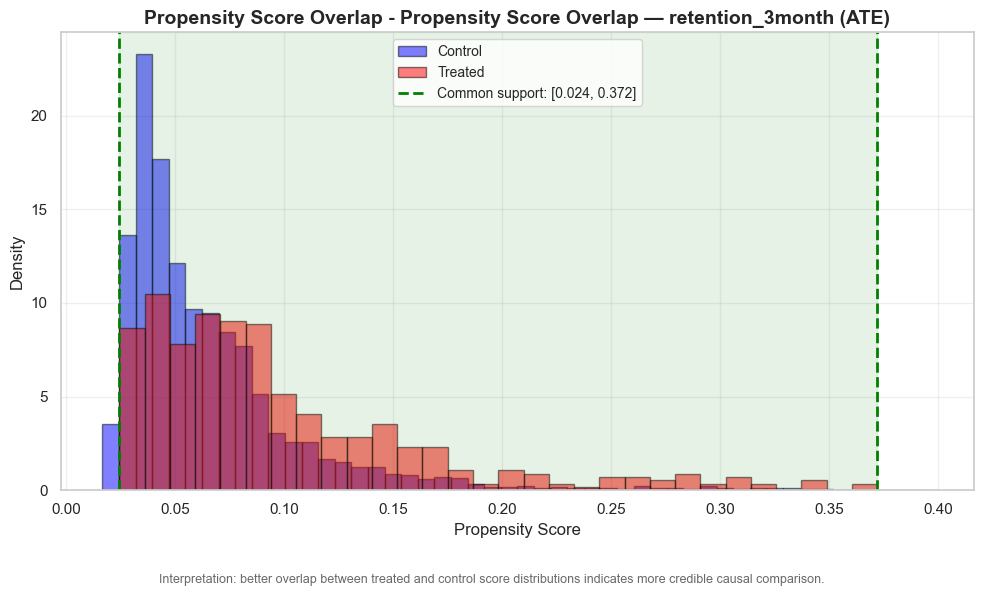

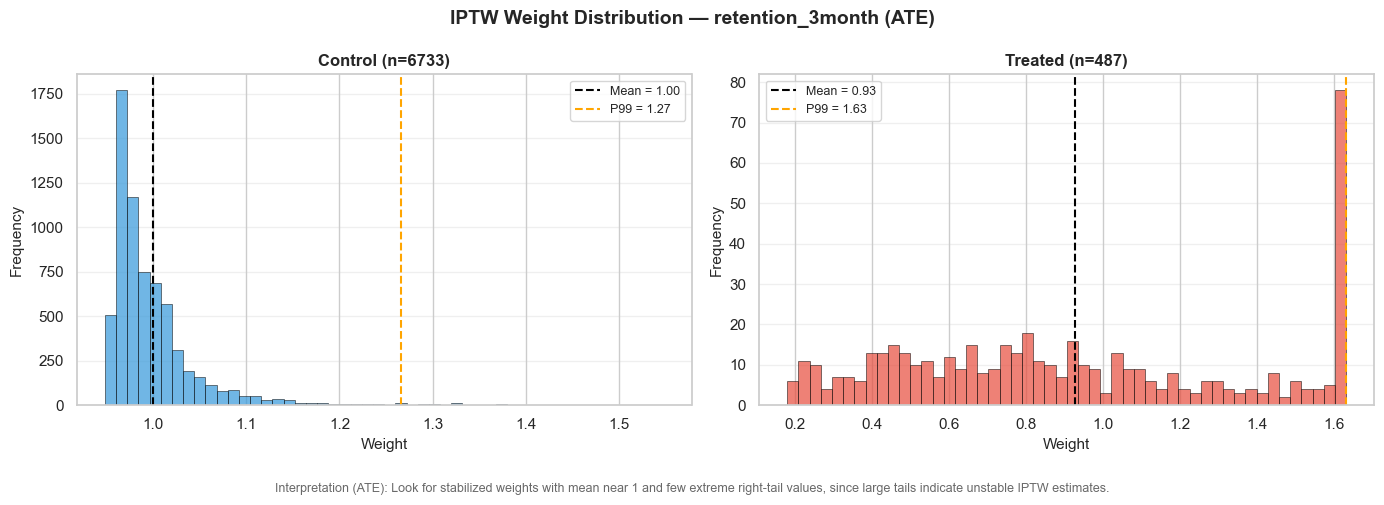

  Auto-detected binary outcome 'retention_3month' → using Binomial family
  [retention_3month] ATE = 0.5818 (95% CI: [0.1555, 1.0080]), p = 0.0075 **, Cohen's d = 0.1598


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
28,treatment,0.58176,0.217476,0.155515,1.008005,0.007472,0.05



ANALYZING OUTCOME: retention_6month


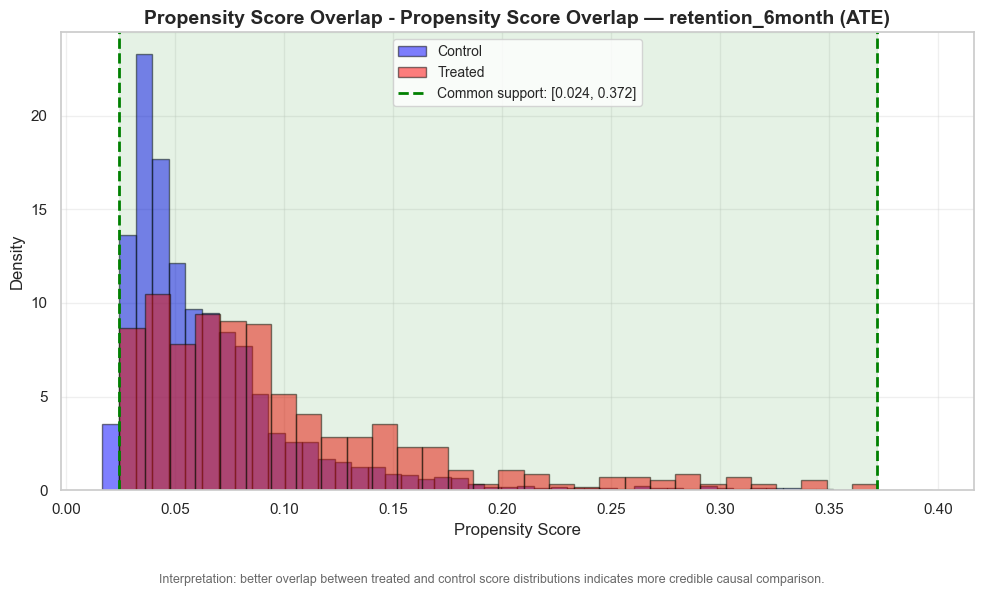

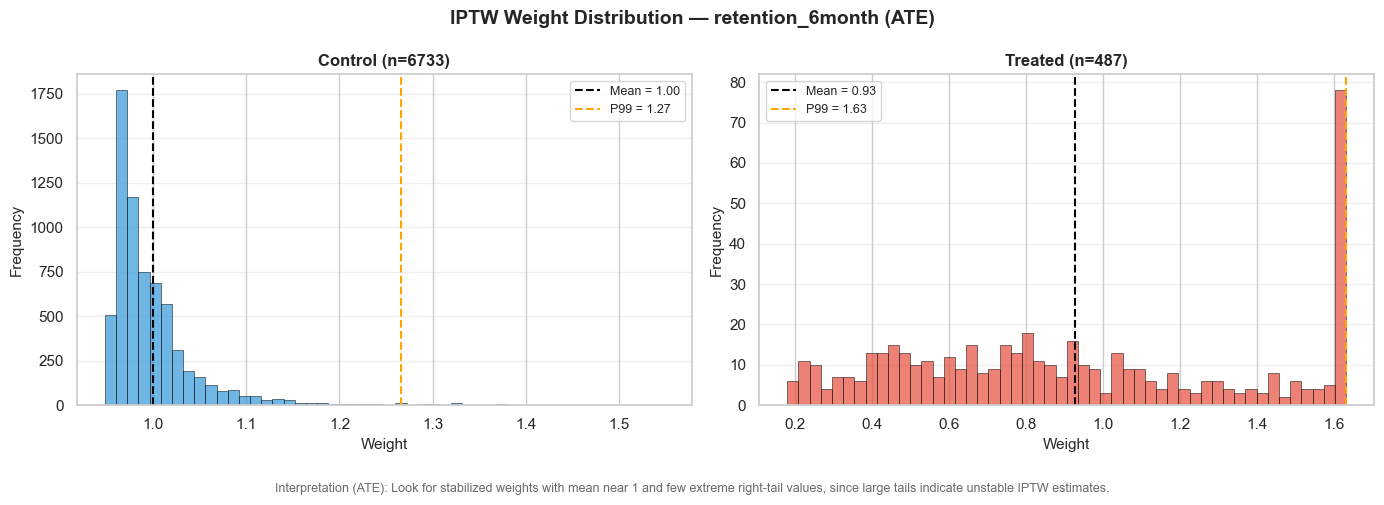

  Auto-detected binary outcome 'retention_6month' → using Binomial family
  [retention_6month] ATE = 0.4477 (95% CI: [0.1013, 0.7941]), p = 0.0113 *, Cohen's d = 0.1454


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
28,treatment,0.447696,0.176755,0.101262,0.79413,0.011314,0.05



ANALYZING OUTCOME: retention_9month


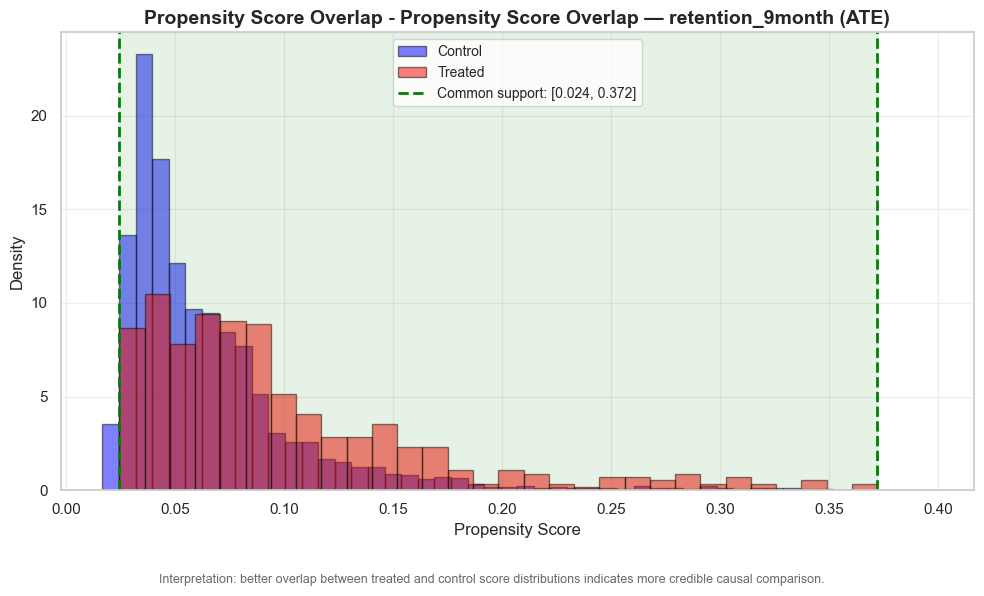

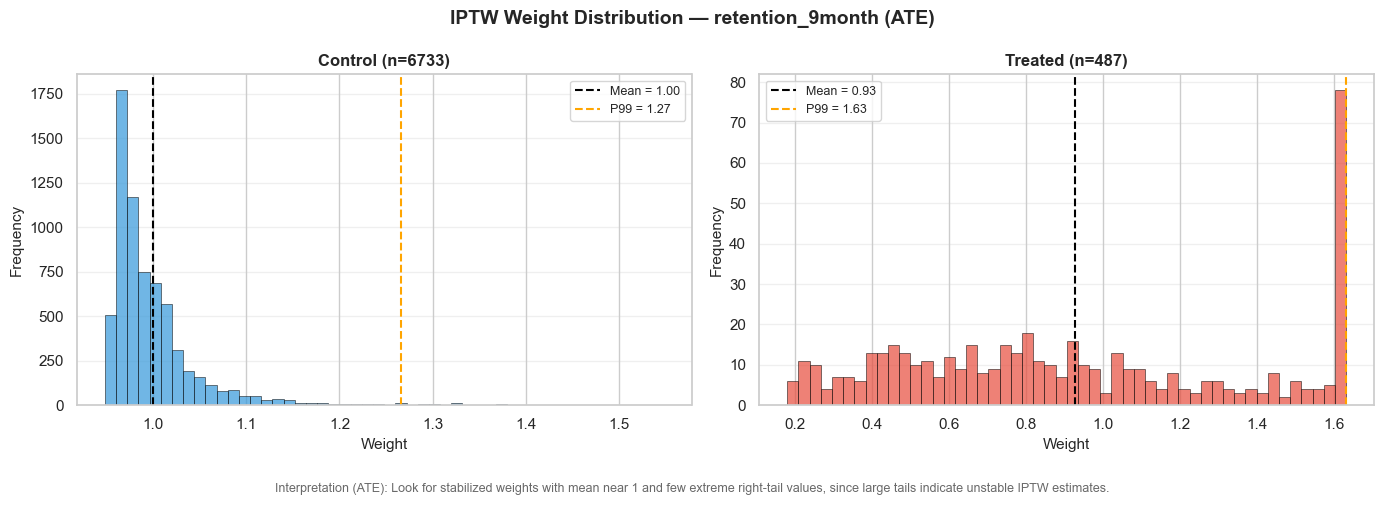

  Auto-detected binary outcome 'retention_9month' → using Binomial family
  [retention_9month] ATE = 0.3793 (95% CI: [0.0707, 0.6879]), p = 0.0160 *, Cohen's d = 0.1354


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
28,treatment,0.379298,0.15747,0.070663,0.687934,0.016009,0.05



ANALYZING OUTCOME: retention_12month


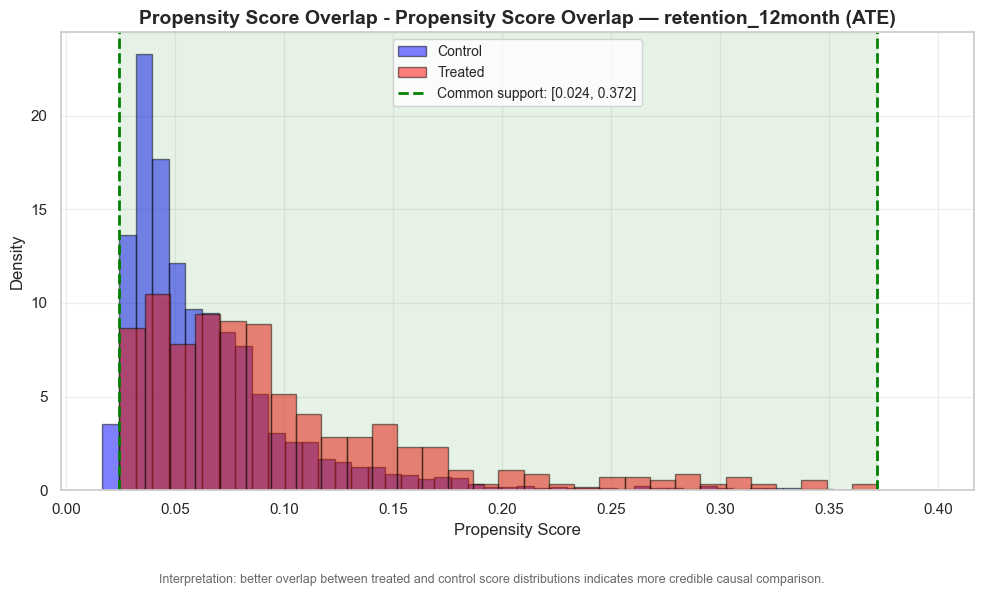

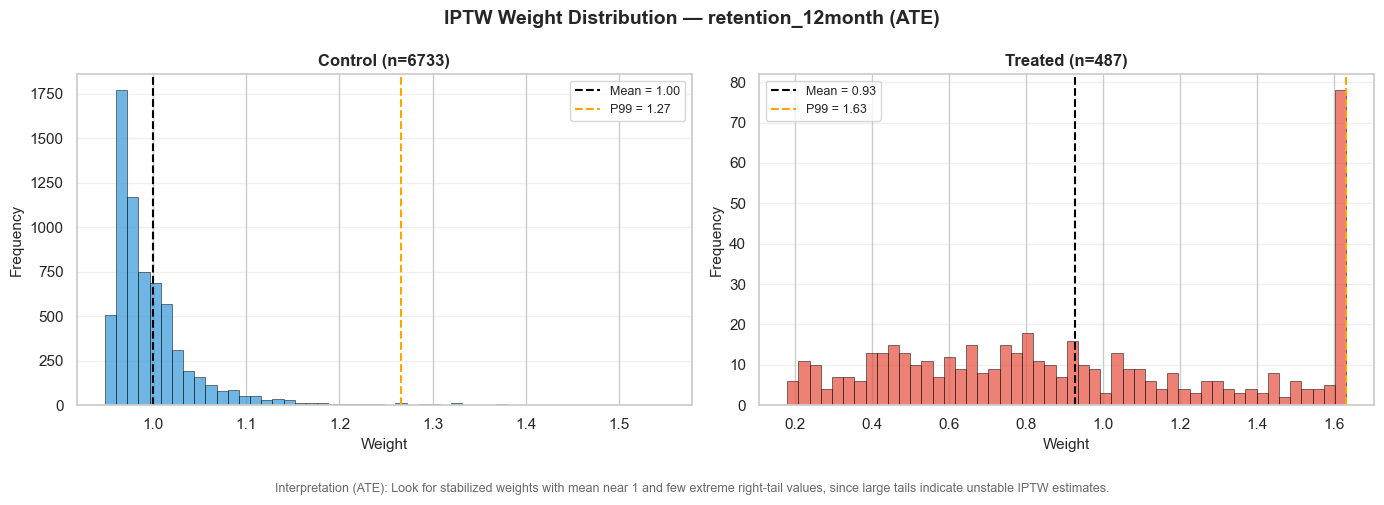

  Auto-detected binary outcome 'retention_12month' → using Binomial family
  [retention_12month] ATE = 0.3308 (95% CI: [0.0475, 0.6140]), p = 0.0221 *, Cohen's d = 0.1247


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
28,treatment,0.330754,0.14451,0.047519,0.613988,0.022091,0.05



  IPTW + GEE: ATE Summary — Retention Outcomes (4 tests)
          Outcome Effect Estimand Std_Error CI_Lower CI_Upper P_Value Cohens_d Pct_Change Mean_Treatment Mean_Control    N    ESS P_Value_Corrected  Significant Significance Correction_Method
 retention_3month 0.5818      ATE    0.2175   0.1555   1.0080  0.0075   0.1598      4.97%         0.9373       0.8929 7220 7099.2            0.0213         True            *            fdr_bh
 retention_6month 0.4477      ATE    0.1768   0.1013   0.7941  0.0113   0.1454      5.56%         0.9017       0.8542 7220 7099.2            0.0213         True            *            fdr_bh
 retention_9month 0.3793      ATE    0.1575   0.0707   0.6879  0.0160   0.1354      5.86%         0.8734       0.8251 7220 7099.2            0.0213         True            *            fdr_bh
retention_12month 0.3308      ATE    0.1445   0.0475   0.6140  0.0221   0.1247      5.99%         0.8445       0.7968 7220 7099.2            0.0221         True            * 

In [23]:
# Instantiate the model
causal_model = IPTWGEEModel()

# --- Family 1: Survey outcomes (continuous, with baselines) ---
survey_outcomes = ['manager_efficacy_index', 'workload_index_mgr', 'turnover_intention_index_mgr']
survey_results = {}

for o in survey_outcomes:
    print("\n" + "=" * 60)
    print(f"ANALYZING OUTCOME: {o}")
    print("=" * 60)
    survey_results[o] = causal_model.analyze_treatment_effect(
        data=manager_df_filtered, #dataframe to analyze
        outcome_var=o, #outcome variable to analyze
        treatment_var=treatment, #treatment variable
        estimand='ATE', #causal estimand to estimate 
        categorical_vars=categorical_vars, #list of categorical covariates to adjust for; these will be one-hot encoded by the model
        binary_vars=binary_vars, #list of binary covariates to adjust for; these will be treated as 0/1 flags by the model
        continuous_vars=continuous_vars, #list of continuous covariates to adjust for; used as is in the model
        cluster_var='manager_id', #variable to cluster standard errors by (e.g. clustering by manager accounts for team-level shocks)
        baseline_var=baseline_vars.get(o), #baseline control variable for survey outcomes
        project_path= base_dir / "results", # None or set to a path to save model outputs 
        trim_quantile=0.99, #quantile for trimming extreme propensity scores (e.g. 0.99 will trim the top 1% most extreme scores); set to None to disable trimming
        analysis_name=f"IPTW_GEE_{o}", #name for this analysis (used in saved outputs if project_path is set)
        correction_method='fdr_bh', #method for multiple testing correction across outcomes (options: 'fdr_bh', 
        alpha=0.05 #significance level for confidence intervals and multiple testing correction
    )
    display(survey_results[o]['coefficients_df'])

survey_summary = IPTWGEEModel.build_summary_table(  # CHANGED HERE
    survey_results,
    title="IPTW + GEE: ATE Summary — Survey Outcomes (3 tests)",
    save_path=str(base_dir / "results" / "ate_summary_survey.xlsx")
)

# --- Family 2: Retention outcomes (binary, no baselines) ---
retention_outcomes = ['retention_3month', 'retention_6month', 'retention_9month', 'retention_12month']
retention_results = {}

for o in retention_outcomes:
    print("\n" + "=" * 60)
    print(f"ANALYZING OUTCOME: {o}")
    print("=" * 60)
    retention_results[o] = causal_model.analyze_treatment_effect(
        data=manager_df_filtered,
        outcome_var=o,
        treatment_var=treatment,
        estimand='ATE',
        categorical_vars=categorical_vars,
        binary_vars=binary_vars,
        continuous_vars=continuous_vars,
        cluster_var='manager_id',
        baseline_var=baseline_vars.get(o),
        project_path=base_dir / "results",
        trim_quantile=0.99,
        analysis_name=f"IPTW_GEE_{o}",
        correction_method='fdr_bh',
        alpha=0.05
    )
    display(retention_results[o]['coefficients_df'])

retention_summary = IPTWGEEModel.build_summary_table(  # CHANGED HERE
    retention_results,
    title="IPTW + GEE: ATE Summary — Retention Outcomes (4 tests)",
    save_path=str(base_dir / "results" / "ate_summary_retention.xlsx")
)

# =============================================================================
# INDEPENDENT POST-WEIGHTING BALANCE VERIFICATION
# =============================================================================
# analyze_treatment_effect delegates balance computation to
# CausalDiagnostics.compute_balance_df(), creating a single source of truth for
# SMD calculations across diagnostics and modeling modules.
#
# This section independently cross-checks balance by calling
# cd.compute_balance_df() on weighted data returned by the model and comparing
# against each outcome's model-generated balance_df.

def verify_balance(results_dict, family_label, cd_instance, treatment_var,
                   categorical_vars, binary_vars, continuous_vars):
    """
    Independent cross-check of post-weighting covariate balance.
    Uses CausalDiagnostics.compute_balance_df() on the weighted_df returned
    by analyze_treatment_effect, and compares against the model's balance_df.
    """
    for outcome, res in results_dict.items():
        wdf = res.get('weighted_df')
        if wdf is None:
            print(f"  [{outcome}] No weighted_df in results - skipping.")
            continue

        # Identify balance covariates (same ones used by analyze_treatment_effect)
        balance_cols = [c for c in wdf.columns
                        if c not in [outcome, treatment_var, 'manager_id',
                                     'propensity_score', 'iptw']]

        independent_balance = cd_instance.compute_balance_df(
            data=wdf,
            controls=balance_cols,
            treatment=treatment_var,
            weights=wdf['iptw'],
            already_encoded=True,
        )

        # Flag any covariates with weighted |SMD| > 0.1
        imbalanced = independent_balance[independent_balance['Weighted SMD'].abs() > 0.1]
        n_imbal = len(imbalanced)

        model_bal = res['balance_df']
        n_model_imbal = model_bal['balanced_after_weighting'].eq(False).sum() if 'balanced_after_weighting' in model_bal.columns else '?'

        status = '\u2705' if n_imbal == 0 else '\u26a0\ufe0f'
        print(f"  {status} [{outcome}]  Independent imbalanced: {n_imbal}  |  Model imbalanced: {n_model_imbal}")
        if n_imbal > 0:
            display(imbalanced)

print('=' * 60)
print('BALANCE VERIFICATION - Survey Outcomes')
print('=' * 60)
verify_balance(survey_results, 'Survey', cd, treatment,
               categorical_vars, binary_vars, continuous_vars)

print()
print('=' * 60)
print('BALANCE VERIFICATION - Retention Outcomes')
print('=' * 60)
verify_balance(retention_results, 'Retention', cd, treatment,
               categorical_vars, binary_vars, continuous_vars)

In [24]:
# =============================================================================
# E-VALUE SENSITIVITY ANALYSIS
# =============================================================================
# Compute E-values to assess robustness to unmeasured confounding

print("\n" + "=" * 70)
print("E-VALUE SENSITIVITY ANALYSIS - Survey Outcomes")
print("=" * 70)

# For survey outcomes (continuous), use Cohen's d
survey_evalues = IPTWGEEModel.compute_evalues_from_results(
    survey_results,
    effect_type="cohens_d"
)

print("\n" + "=" * 70)
print("E-VALUE SENSITIVITY ANALYSIS - Retention Outcomes")
print("=" * 70)

# For retention outcomes (binary), use log-odds from the GEE model
retention_evalues = IPTWGEEModel.compute_evalues_from_results(
    retention_results,
    effect_type="log_odds",
    outcome_rare=False  # Retention rates are high (not rare)
)

# Save E-value results
survey_evalues.to_excel(base_dir / "results" / "evalue_survey.xlsx", index=False)
retention_evalues.to_excel(base_dir / "results" / "evalue_retention.xlsx", index=False)


E-VALUE SENSITIVITY ANALYSIS - Survey Outcomes

  E-VALUE SENSITIVITY ANALYSIS
                     Outcome Effect_Type  Effect_Value  Effect_RR  E_Value_Point  E_Value_CI Robustness      P_Value  Significant
      manager_efficacy_index    cohens_d      0.478863   1.546145       2.465069    2.017578   Moderate 8.150041e-24         True
          workload_index_mgr    cohens_d     -0.059288   1.055434       1.297317    1.482896  Very Weak 3.315636e-01        False
turnover_intention_index_mgr    cohens_d      0.268402   1.276658       1.870963    1.546920       Weak 8.028324e-08         True
  Interpretation Guide:
    E-value ≥ 3.0 : Strong robustness to unmeasured confounding
    E-value 2.0-3.0: Moderate robustness
    E-value 1.5-2.0: Weak robustness - interpret with caution
    E-value < 1.5 : Very weak - easily explained by confounding

  Per-Outcome Interpretations (significant results only):
----------------------------------------------------------------------

  manager_effi

### ATE Technical Summary
Note: None of these results generalize to poor performers.

#### Family 1: Survey Outcomes (Continuous, 3 tests, FDR-corrected)

| Outcome | ATE | 95% CI | p (corrected) | Cohen's d | Significant? |
|---------|-----|--------|---------------|-----------|-------------|
| Manager Efficacy Index | **+0.40** | [0.32, 0.48] | < 0.0001 | 0.48 | Yes *** |
| Workload Index | **−0.04** | [−0.12, 0.04] | 0.332 | −0.06  | No |
| Turnover Intention Index | **+0.23** | [0.15, 0.32] | < 0.0001 | 0.27  | Yes *** |

**Manager Efficacy Index** — *Strongest effect observed*
- Trained managers reported substantially higher self-assessed leadership efficacy
- ATE of **+0.40** (Cohen's d = 0.48), representing a **+12.0% relative improvement** vs. controls

**Turnover Intention (Stay Intent)**
- Trained managers reported meaningfully higher intention to stay
- ATE of **+0.23** (Cohen's d = 0.27), representing a **+9.1% relative improvement** vs. controls

**Workload Index** — *No effect detected*
- ATE of **−0.04**, not statistically significant (p = 0.332)
- The program neither increases nor decreases perceived workload

#### Family 2: Retention Outcomes (Binary/Logit, 4 tests, FDR-corrected)

| Outcome | ATE (log-odds) | Odds Ratio | 95% CI (log-odds) | p (corrected) | Significant? |
|---------|----------------|------------|-------------------|---------------|-------------|
| 3-Month Retention | **+0.58** | 1.79 | [0.16, 1.01] | 0.021 | Yes * |
| 6-Month Retention | **+0.45** | 1.56 | [0.10, 0.79] | 0.021 | Yes * |
| 9-Month Retention | **+0.38** | 1.46 | [0.07, 0.69] | 0.021 | Yes * |
| 12-Month Retention | **+0.33** | 1.39 | [0.05, 0.61] | 0.022 | Yes * |

- All retention outcomes are statistically significant after FDR correction, indicating odds of retention under training ranging from 79% (3-months) to 39% (12-months) with effect sizes ranging from 0.12–0.16.
- The treatment effect on retention **attenuates over time** (strongest at 3 months, weakest at 12 months), consistent with a training effect that fades without reinforcement.
- Trained managers had ~5–6% higher retention rates at each time point compared to controls.

**How to read the odds ratios:**
An odds ratio (OR) above 1.0 means trained managers were *more likely* to retain their reports than untrained managers. For example, an OR of **1.79 at 3 months** means the odds of an employee being retained under a trained manager were **79% higher** than under an untrained manager. As the OR approaches 1.0, the treatment effect weakens.

#### Post-Weighting Balance Verification
- All 7 outcomes passed independent balance verification (0 imbalanced covariates for every model).
- This confirms that IPTW successfully balanced observed confounders across treatment groups.

#### E-Value Sensitivity Analysis

E-values quantify the minimum strength of association an unmeasured confounder would need with *both* treatment and outcome to fully explain away the observed effect. Higher E-values indicate greater robustness to unmeasured confounding.

| Outcome | E-Value Point | E-Value CI | Robustness |
|---------|---------------|------------|------------|
| Manager Efficacy Index | **2.47** | **2.02** | Moderate |
| Workload Index | 1.30 | 1.48 | Very Weak (ns) |
| Turnover Intention Index | **1.87** | **1.55** | Weak |
| 3-Month Retention | **2.01** | **1.38** | Moderate |
| 6-Month Retention | **1.81** | **1.29** | Weak |
| 9-Month Retention | **1.71** | **1.23** | Weak |
| 12-Month Retention | **1.64** | **1.18** | Weak |

**How to read E-values:** The E-value for the point estimate is the minimum risk ratio association an unmeasured confounder would need with *both* treatment and outcome to fully explain away the effect. The E-value for the CI is the minimum association needed to shift the confidence interval to include the null (i.e., render the result non-significant). Values are bolded for significant outcomes only.

**Significant outcome interpretations:**

- **Manager Efficacy Index:** E-value = 2.47. An unmeasured confounder would need risk ratio associations of at least 2.47 with both treatment and outcome to explain away this effect. This represents moderate robustness. A confounder of strength 2.02 could shift the CI to include the null.

- **Turnover Intention Index:** E-value = 1.87. A relatively weak unmeasured confounder (RR ≈ 1.87) could potentially explain this effect. Interpret with caution. A confounder of strength 1.55 could shift the CI to include the null.

- **3-Month Retention:** E-value = 2.01. An unmeasured confounder would need risk ratio associations of at least 2.01 with both treatment and outcome to explain away this effect. This represents moderate robustness. A confounder of strength 1.38 could shift the CI to include the null.

- **6-Month Retention:** E-value = 1.81. A relatively weak unmeasured confounder (RR ≈ 1.81) could potentially explain this effect. Interpret with caution. A confounder of strength 1.29 could shift the CI to include the null.

- **9-Month Retention:** E-value = 1.71. A relatively weak unmeasured confounder (RR ≈ 1.71) could potentially explain this effect. Interpret with caution. A confounder of strength 1.23 could shift the CI to include the null.

- **12-Month Retention:** E-value = 1.64. A relatively weak unmeasured confounder (RR ≈ 1.64) could potentially explain this effect. Interpret with caution. A confounder of strength 1.18 could shift the CI to include the null.

## Key Findings & Recommendations for L&D

### Bottom Line

The manager training program works. It meaningfully improves how managers perceive their own leadership capability, increases their intent to stay, and produces real retention gains for their direct reports — all without adding to perceived workload. However, the retention benefit fades over time, pointing to a clear opportunity for L&D to extend the program's impact.

> **Scope:** These findings apply to the general manager population and do not generalize to poor performers.

---

### Key Findings

#### 1. Manager Confidence Gets a Significant Boost
- Trained managers scored **12% higher** on self-assessed leadership efficacy compared to untrained peers
- This was the **strongest and most robust effect** in the entire study (Cohen's d = 0.48, a medium-sized effect; E-value = 2.47)
- **What this means for L&D:** The program is landing. Managers are walking away feeling materially more equipped to lead. This is a strong signal that the content and delivery are resonating. The E-value of 2.47 indicates this finding is moderately robust to unmeasured confounding — an unmeasured factor would need to be quite strongly associated with both training participation and efficacy to explain this effect away.

#### 2. Trained Managers Are More Likely to Stay
- Trained managers reported **9.1% higher intention to stay** vs. controls
- E-value = 1.87, indicating weak-to-moderate robustness (interpret with appropriate caution)
- **What this means for L&D:** The program isn't just building skills — it's building commitment. Investing in managers appears to signal organizational investment back to them, reinforcing retention at the manager level itself. While this finding is statistically significant, it is more vulnerable to unmeasured confounding than the efficacy result, so consider it a promising signal rather than definitive proof.

#### 3. The Program Does Not Add to Workload
- No statistically significant change in perceived workload (p = 0.332)
- **What this means for L&D:** This is an important "no harm" finding. A common objection to new training programs is that they pile on more work. This data shows that concern is unfounded here — the program delivers benefits without a workload cost.

#### 4. Direct Report Retention Improves — But the Effect Fades

| Time After Training | Retention Advantage (Odds Ratio) | E-Value (Point) | Robustness |
|---|---|---|---|
| 3 months | **1.79** (79% higher odds) | 2.01 | Moderate |
| 6 months | **1.56** (56% higher odds) | 1.81 | Weak |
| 9 months | **1.46** (46% higher odds) | 1.71 | Weak |
| 12 months | **1.39** (39% higher odds) | 1.64 | Weak |

- Trained managers consistently retained more of their people at every time point (~5–6 percentage points higher retention)
- However, the effect **weakens steadily** from 3 to 12 months — the classic decay curve of a one-time training intervention
- **Robustness note:** The 3-month retention effect is moderately robust (E-value = 2.01), but longer-horizon effects become increasingly vulnerable to unmeasured confounding. This pattern reinforces the interpretation that the training effect is real but fades without reinforcement.

---

### Recommendations

#### ✅ Keep the Program — The Evidence Supports It
The program delivers on its core promises: stronger manager confidence, higher stay intent, and measurable retention gains. These are not marginal effects — they are statistically robust and practically meaningful. The causal methodology and sensitivity analyses provide strong evidence that these effects are attributable to the training itself.

#### 🔄 Introduce Reinforcement to Sustain Retention Gains
The attenuation pattern (OR declining from 1.79 → 1.39, with weakening E-values over time) is the single most actionable finding for L&D. The training works, but its impact on retention erodes without follow-up. Consider:
- **Booster sessions** at 3- and 6-month marks to refresh key concepts and arrest the decay curve
- **Peer learning cohorts** that keep trained managers connected and practicing
- **Manager toolkits or nudges** (e.g., monthly micro-prompts) to reinforce behaviors between formal sessions
- **Follow-up coaching** targeted at the specific leadership behaviors the program teaches
- **Measurement:** If you implement reinforcement, track retention at 6 and 12 months to see if the decay curve flattens

#### 📊 Use These Results to Build the Business Case
This study provides **causal evidence** (not just correlational) that the program drives outcomes. The methodology (inverse probability weighting with doubly robust estimation and full covariate balance) means you can confidently say the training *caused* these improvements, not that better managers simply self-selected into the program. The E-value sensitivity analyses further strengthen this claim by quantifying robustness to unmeasured confounding.

**Key talking points for stakeholders:**
- "Manager efficacy improved by 12%, with an E-value of 2.47 — meaning an unmeasured confounder would need to be quite strong to explain this away"
- "Retention improved by 5–6 percentage points at every time horizon, with the strongest effect at 3 months (79% higher odds)"
- "All observed confounders were successfully balanced, and the program had no negative impact on workload"

#### 🔍 Explore the Poor Performer Gap
These results explicitly exclude poor performers. A natural next question for L&D: does the program work differently for managers who are struggling? This could inform whether the program needs a separate track or additional support layer for that population. Given that the current results show moderate-to-weak robustness for some outcomes, understanding heterogeneity in treatment effects could help target resources more effectively.

#### ⚠️ Acknowledge Limitations Transparently
While the findings are encouraging, they are not bulletproof:
- **Unmeasured confounding remains possible.** E-values indicate that weaker unmeasured factors (e.g., manager motivation, team culture) could potentially explain some effects, particularly the longer-horizon retention outcomes.
- **The study is observational, not experimental.** A randomized controlled trial would provide stronger causal evidence, though the current design is rigorous for an observational study.
- **Generalizability is limited.** Results apply to the general manager population who participated; they do not extend to poor performers or managers who declined training.

Being transparent about these limitations strengthens credibility and sets realistic expectations for program impact.

---

## What if we couldn't sufficiently balance the model for estimating ATE?

### Estimating Average Treatment Effect on the Treated (ATT) using IPTW + GEE
---

### When to Use ATT Instead of ATE

| Consideration | ATE | ATT |
|---------------|-----|-----|
| **Target population** | Full population (treated + untreated) | Only those who received treatment |
| **Research question** | "What would happen if we rolled this out to everyone?" | "Did the program work for those who actually participated?" |
| **Overlap requirement** | Strict: every covariate profile needs both treated and control individuals | Relaxed: only need controls that resemble the treated |
| **Typical use case** | Policy decisions about universal rollout | Evaluating a voluntary or targeted program |
| **When treated group is small** | Problematic — requires extrapolating to dissimilar individuals | Natural fit — you're only generalizing to the treated |

**Use ATT when:**
- The treated group is small relative to controls
- Many controls have no comparable treated individual (but the reverse is fine)
- You want to evaluate whether the treatment worked *for those who received it*, not whether it would work for everyone
- Full-population overlap is poor, but one-directional overlap (controls → treated) is adequate

---

### What Stays the Same

The following elements are **identical** to the ATE approach:

- GEE model structure: $g\big(E[Y_i]\big) = \beta_0 + \beta_1 \cdot Treatment_i + \beta_2 \cdot X_i$
- Link functions: identity for continuous outcomes, logit for binary
- Propensity score estimation: $\hat{e}_i = P(Treatment_i = 1 \mid X_i)$
- Clustering by team (manager ID) with sandwich standard errors
- Doubly robust property: consistent if either PS model or outcome model is correct
- Weight trimming and propensity score clipping mechanics
- Multiple testing correction across outcomes

---

### What Changes: The Weights

This is the **only substantive difference** — the weight formula determines the estimand.

| Group | ATE Weights | ATT Weights |
|-------|-------------|-------------|
| **Treated** | $w_i = 1 \;/\; \hat{e}_i$ | $w_i = 1$ |
| **Control** | $w_i = 1 \;/\; (1 - \hat{e}_i)$ | $w_i = \hat{e}_i \;/\; (1 - \hat{e}_i)$ |
| **What it does** | Reweights **both** groups to represent full population | Reweights **only controls** to match the treated group |

**Intuition for ATT weights:**
- Treated individuals already represent themselves — no reweighting needed (weight = 1)
- Controls are reweighted to *look like* the treated group:
  - High propensity score → "this control looks like someone who would have been treated" → upweight
  - Low propensity score → "this control looks nothing like treated individuals" → downweight
- The weighted control group becomes a synthetic comparison group that mirrors the treated on observed covariates

**Stabilization under ATT:**
- Treated: $w_i^{stab} = 1$ (unchanged)
- Control: $w_i^{stab} = \bar{p} \cdot \hat{e}_i \;/\; (1 - \hat{e}_i)$

Stabilization only affects control weights under ATT, since treated weights are already fixed at 1.

---

### What Changes: The Positivity Assumption

| Assumption | ATE Requirement | ATT Requirement |
|------------|-----------------|-----------------|
| **Positivity** | $0 < P(T=1 \mid X) < 1$ for **all** individuals | $P(T=0 \mid X) > 0$ for **treated** individuals only |
| **In plain language** | Every covariate profile needs both treated and control individuals | Every treated individual needs comparable controls |
| **What can be violated** | Neither direction can have gaps | Controls with no comparable treated are fine |

This relaxed requirement is why ATT is often feasible when ATE is not — you only need overlap in one direction.

---

### Interpretation Differences

**Continuous outcomes:**
- ATE: "On average across the population, treatment shifts the outcome by $\beta_1$ units"
- ATT: "On average among those who received treatment, treatment shifts the outcome by $\beta_1$ units"

**Binary outcomes:**
- ATE: $e^{\beta_1}$ = odds ratio averaged across the full population
- ATT: $e^{\beta_1}$ = odds ratio averaged across the treated subpopulation

**Key implication:** ATT and ATE will differ when treatment effects are heterogeneous — i.e., when the effect varies across individuals. If treated individuals would benefit more (or less) from treatment than the average person, ATT ≠ ATE.

---

### Summary: ATE vs. ATT Design Choices

| Design Choice | ATE | ATT |
|---------------|-----|-----|
| **Treated weights** | $1 / \hat{e}_i$ | $1$ |
| **Control weights** | $1 / (1 - \hat{e}_i)$ | $\hat{e}_i / (1 - \hat{e}_i)$ |
| **Stabilized treated** | $\bar{p} / \hat{e}_i$ | $1$ |
| **Stabilized control** | $(1-\bar{p}) / (1 - \hat{e}_i)$ | $\bar{p} \cdot \hat{e}_i / (1 - \hat{e}_i)$ |
| **Target population** | Everyone | Treated only |
| **Overlap needed** | Both directions | Controls → Treated only |
| **Typical weight range** | Higher variance (both groups reweighted) | Lower variance (only controls reweighted) |
| **When to prefer** | Universal policy decisions | Evaluating voluntary/targeted programs |

All other model components — GEE structure, clustering, sandwich SEs, doubly robust estimation, trimming, clipping, outcome family detection, FDR correction — remain identical.


ANALYZING OUTCOME: manager_efficacy_index


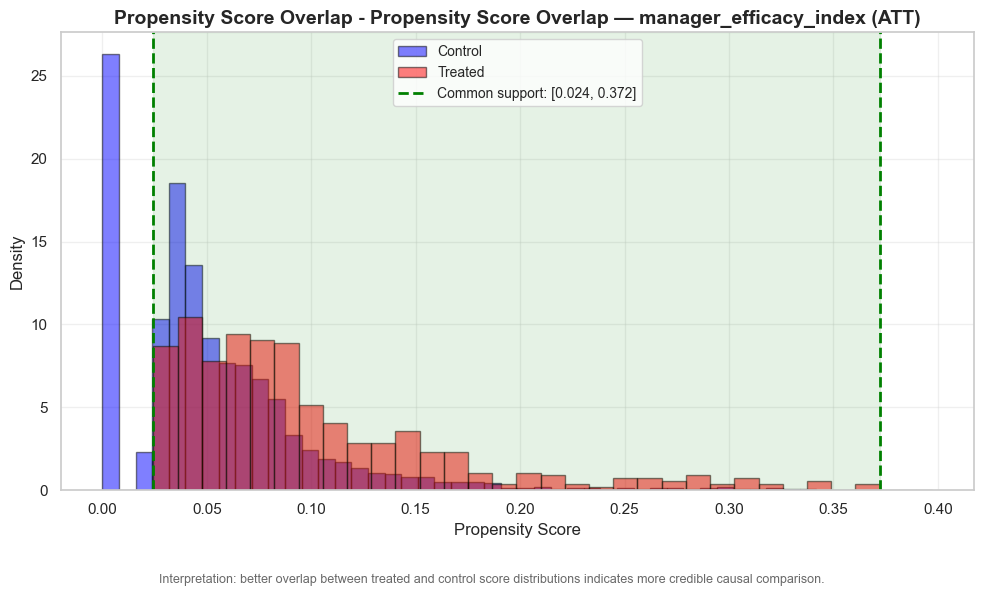

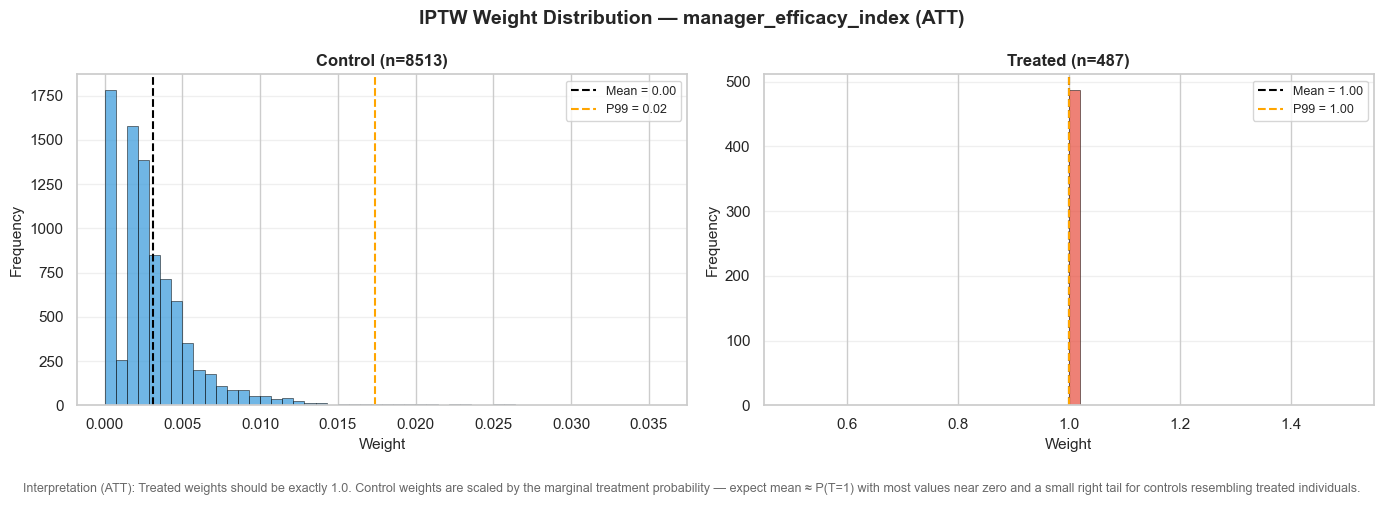

  [manager_efficacy_index] ATT = 0.4117 (95% CI: [0.3411, 0.4823]), p = 0.0000 ***, Cohen's d = 0.4998


c:\Users\U1008500\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1842: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
30,treatment,0.411736,0.03602,0.341138,0.482335,2.936035e-30,0.05



ANALYZING OUTCOME: workload_index_mgr


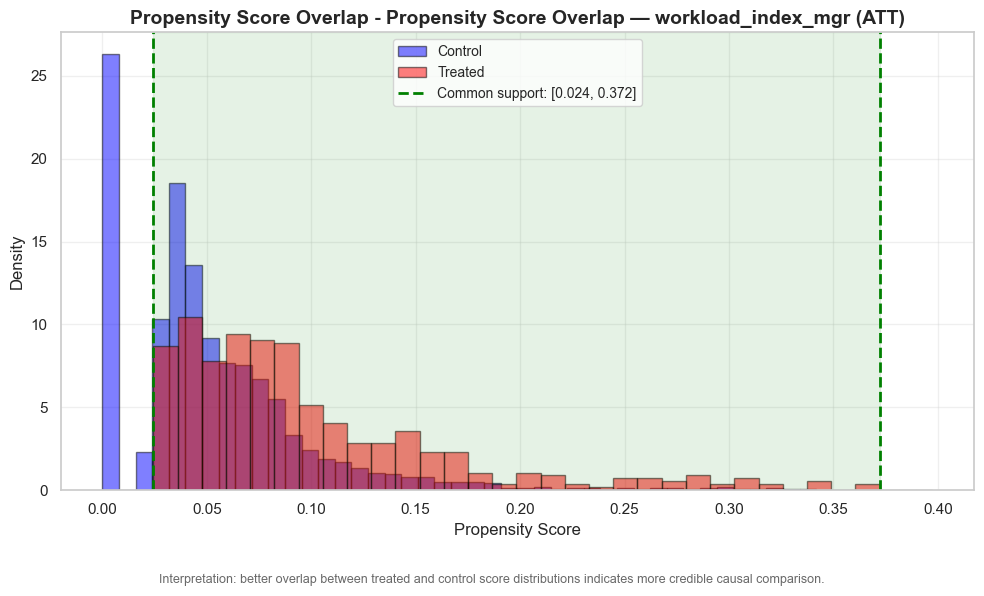

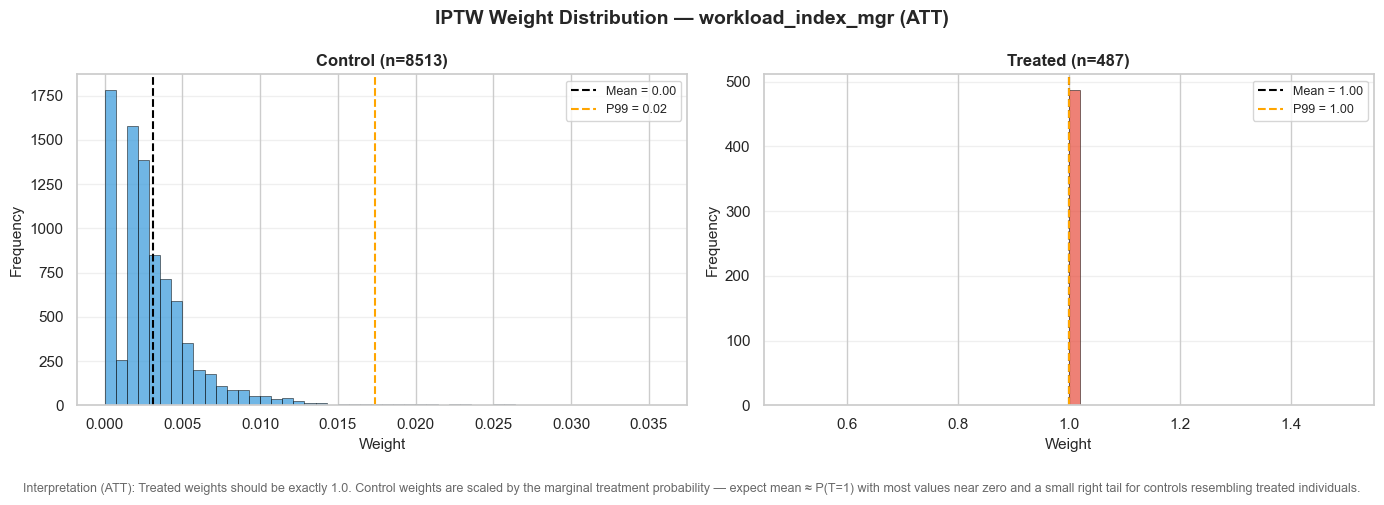

  [workload_index_mgr] ATT = -0.0463 (95% CI: [-0.1225, 0.0299]), p = 0.2340 , Cohen's d = -0.0436


c:\Users\U1008500\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1842: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
30,treatment,-0.046281,0.038884,-0.122491,0.02993,0.233954,0.05



ANALYZING OUTCOME: turnover_intention_index_mgr


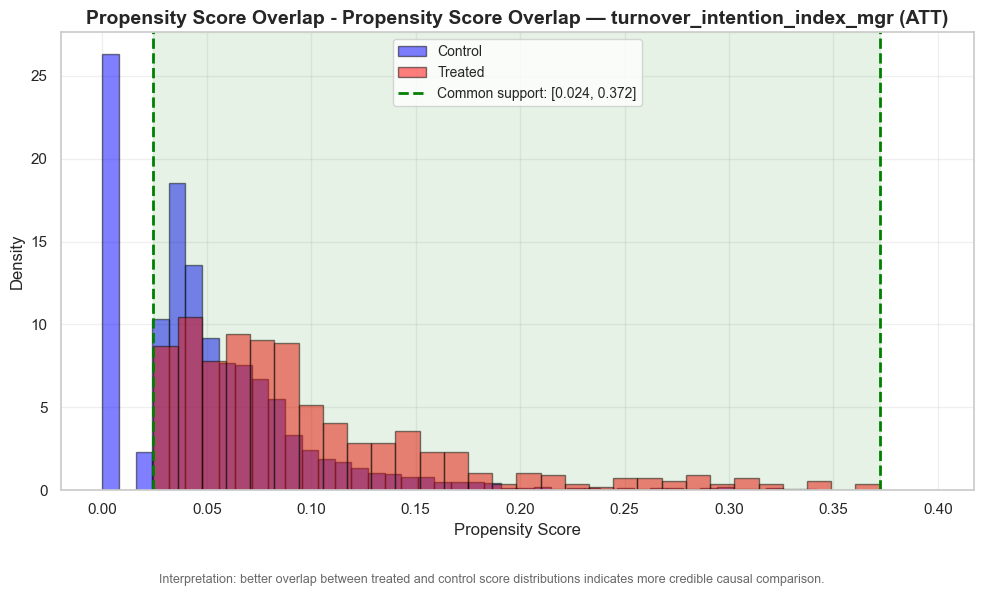

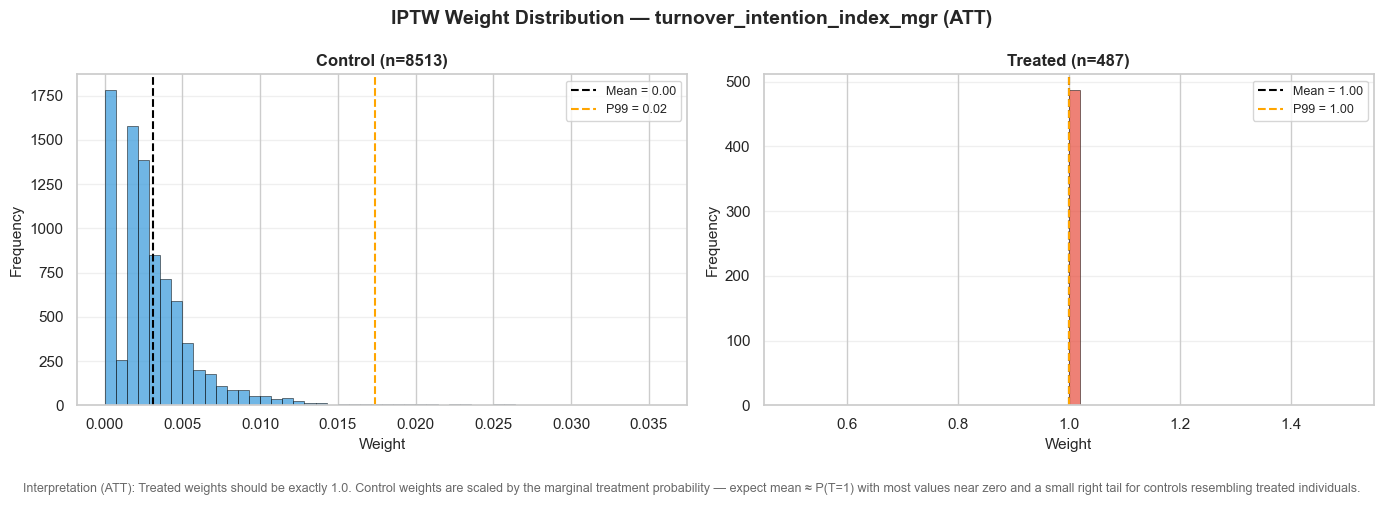

  [turnover_intention_index_mgr] ATT = 0.2589 (95% CI: [0.1846, 0.3332]), p = 0.0000 ***, Cohen's d = 0.2955


c:\Users\U1008500\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1842: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
30,treatment,0.258883,0.037918,0.184565,0.3332,8.643213e-12,0.05



  IPTW + GEE: ATT Summary — Survey Outcomes (3 tests)
                     Outcome  Effect Estimand Std_Error CI_Lower CI_Upper P_Value Cohens_d Pct_Change Mean_Treatment Mean_Control    N   ESS P_Value_Corrected  Significant Significance Correction_Method
      manager_efficacy_index  0.4117      ATT    0.0360   0.3411   0.4823  0.0000   0.4998     12.39%         3.7992       3.3802 9000 541.1            0.0000         True          ***            fdr_bh
          workload_index_mgr -0.0463      ATT    0.0389  -0.1225   0.0299  0.2340  -0.0436     -1.29%         3.1378       3.1787 9000 541.1            0.2340        False                         fdr_bh
turnover_intention_index_mgr  0.2589      ATT    0.0379   0.1846   0.3332  0.0000   0.2955     10.00%         3.0614       2.7831 9000 541.1            0.0000         True          ***            fdr_bh
  Significance: *** p<0.001, ** p<0.01, * p<0.05
  Correction: fdr_bh across 3 outcomes

  Summary table saved to c:\Users\U1008500\O

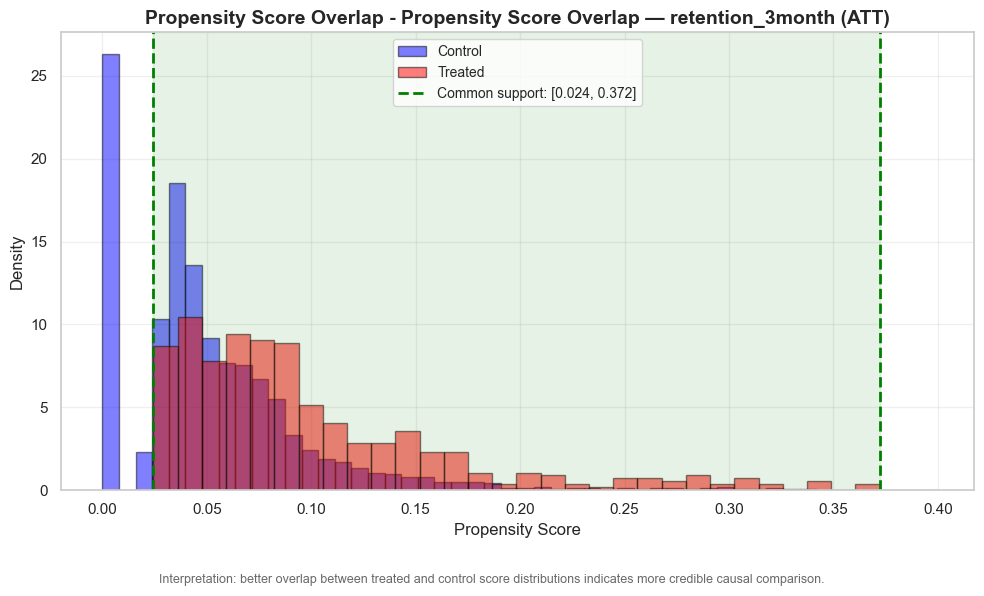

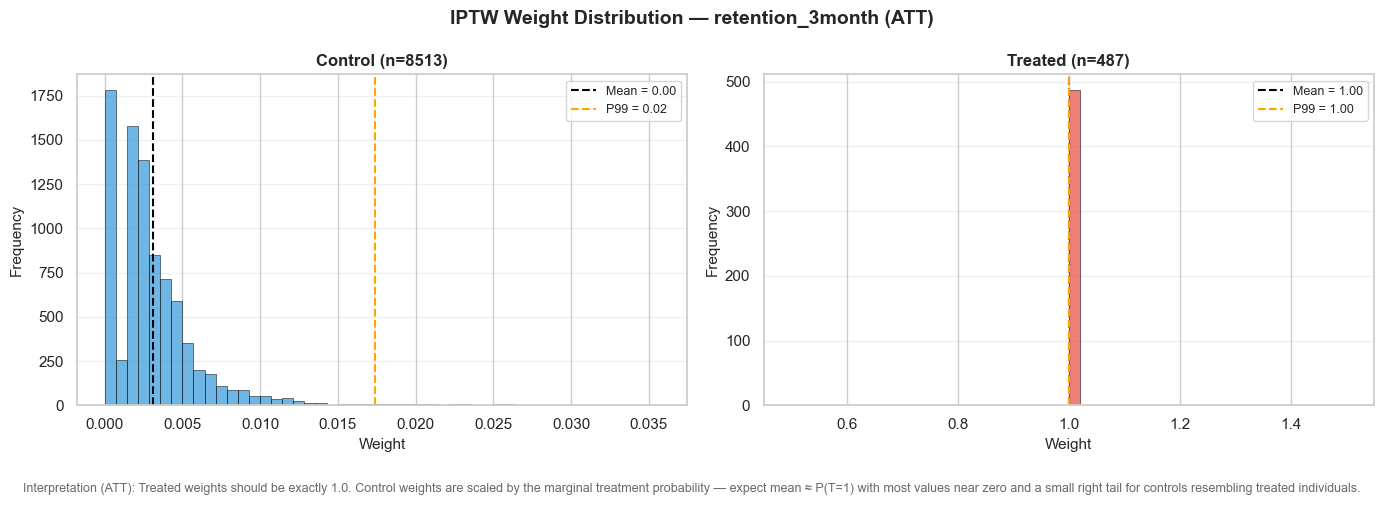

  Auto-detected binary outcome 'retention_3month' → using Binomial family
  [retention_3month] ATT = 0.8122 (95% CI: [0.3865, 1.2380]), p = 0.0002 ***, Cohen's d = 0.1887


c:\Users\U1008500\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1842: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
30,treatment,0.812202,0.217223,0.386453,1.23795,0.000185,0.05



ANALYZING OUTCOME: retention_6month


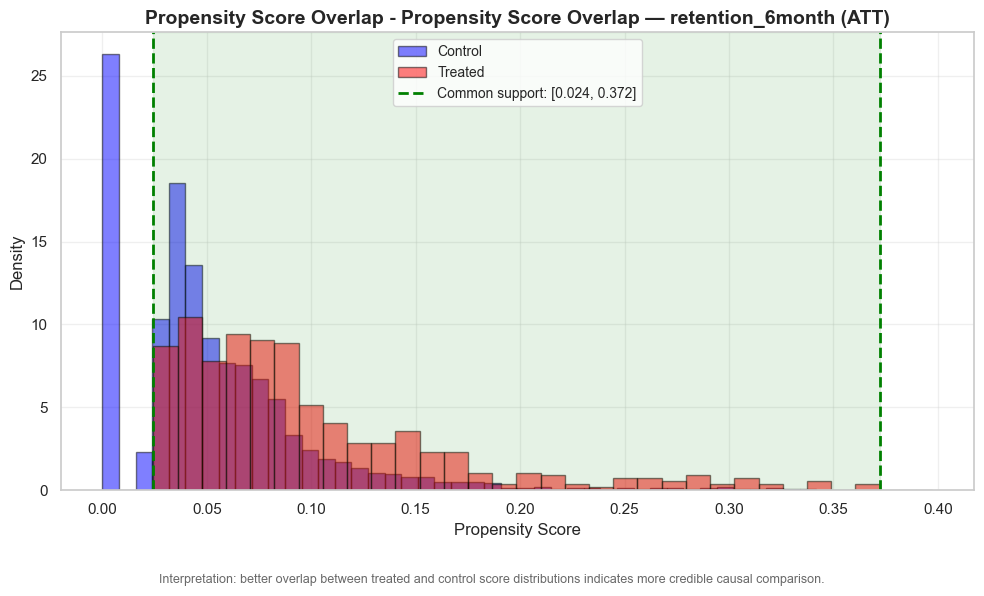

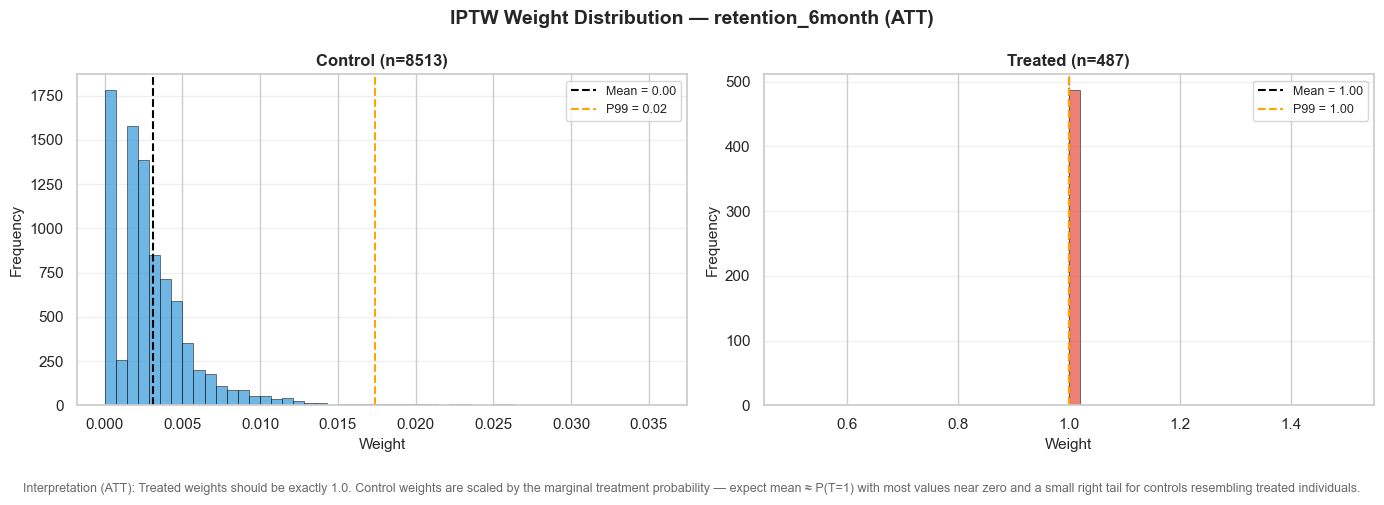

  Auto-detected binary outcome 'retention_6month' → using Binomial family
  [retention_6month] ATT = 0.5969 (95% CI: [0.2563, 0.9374]), p = 0.0006 ***, Cohen's d = 0.1774


c:\Users\U1008500\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1842: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
30,treatment,0.596851,0.173737,0.256332,0.93737,0.000592,0.05



ANALYZING OUTCOME: retention_9month


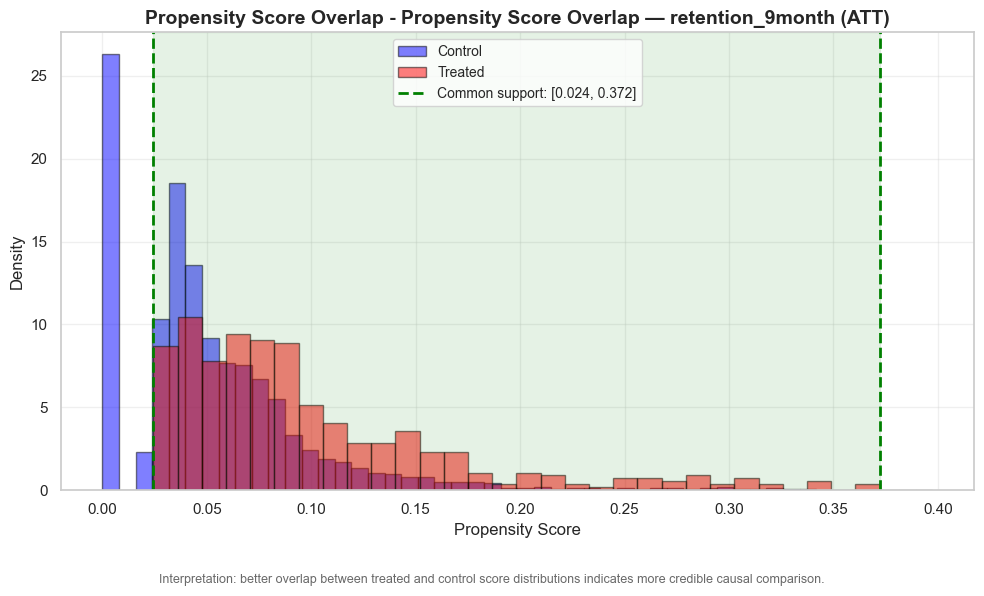

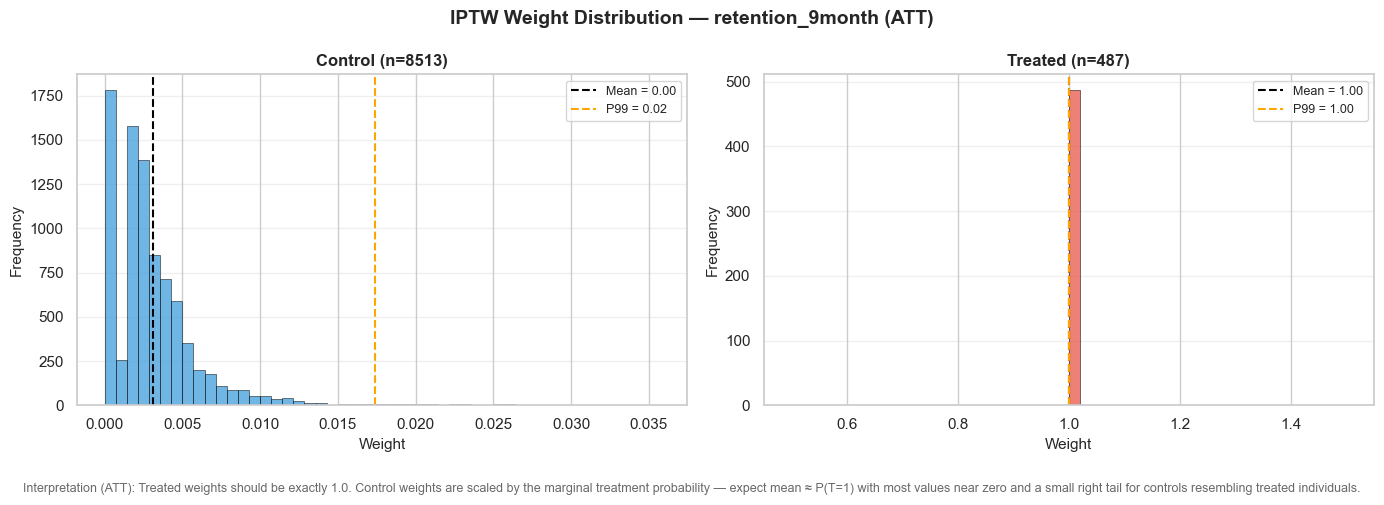

  Auto-detected binary outcome 'retention_9month' → using Binomial family
  [retention_9month] ATT = 0.5243 (95% CI: [0.2222, 0.8264]), p = 0.0007 ***, Cohen's d = 0.1694


c:\Users\U1008500\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1842: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
30,treatment,0.524284,0.154133,0.222188,0.826379,0.00067,0.05



ANALYZING OUTCOME: retention_12month


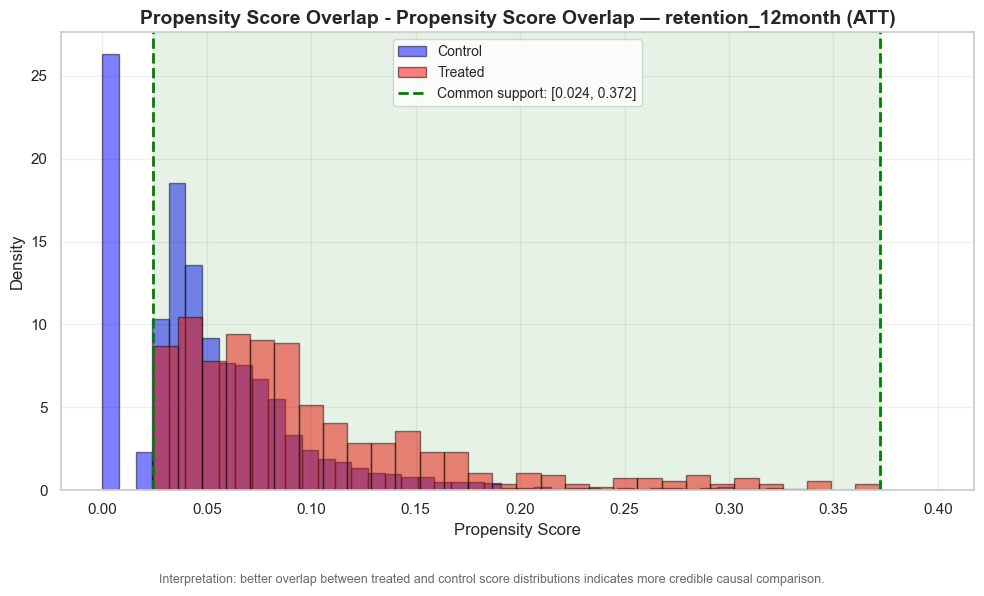

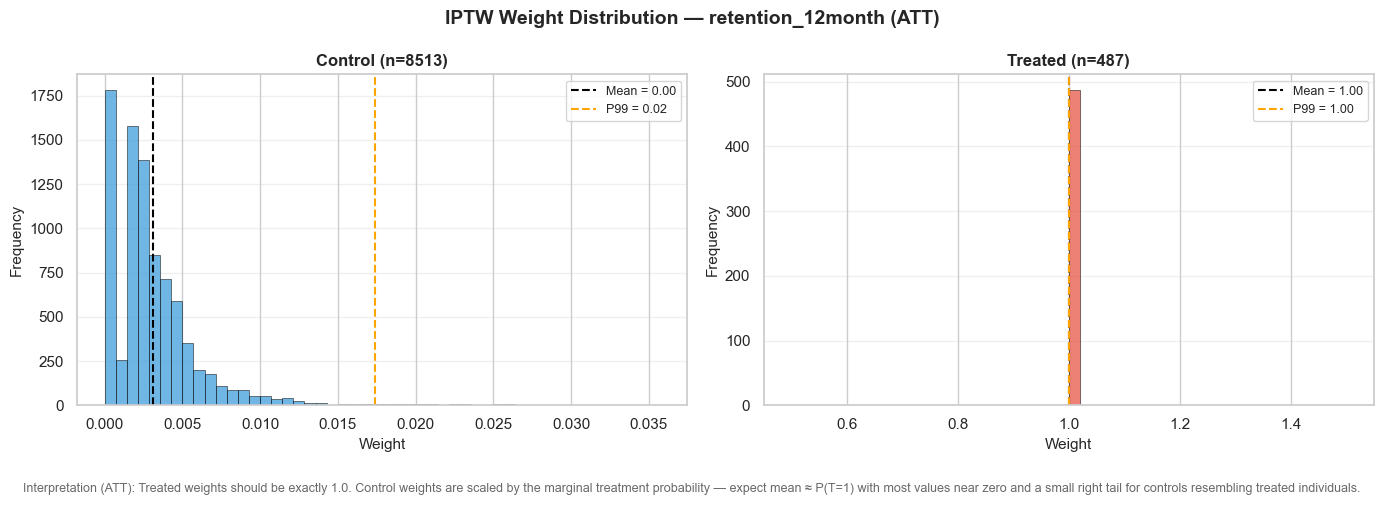

  Auto-detected binary outcome 'retention_12month' → using Binomial family
  [retention_12month] ATT = 0.5111 (95% CI: [0.2293, 0.7928]), p = 0.0004 ***, Cohen's d = 0.1712


c:\Users\U1008500\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1842: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


,Parameter,Estimate,Std_Error,CI_Lower,CI_Upper,P_Value_Raw,Alpha
30,treatment,0.511065,0.143749,0.229322,0.792807,0.000378,0.05



  IPTW + GEE: ATT Summary — Retention Outcomes (4 tests)
          Outcome Effect Estimand Std_Error CI_Lower CI_Upper P_Value Cohens_d Pct_Change Mean_Treatment Mean_Control    N   ESS P_Value_Corrected  Significant Significance Correction_Method
 retention_3month 0.8122      ATT    0.2172   0.3865   1.2380  0.0002   0.1887      5.74%         0.9446       0.8933 9000 541.1            0.0007         True          ***            fdr_bh
 retention_6month 0.5969      ATT    0.1737   0.2563   0.9374  0.0006   0.1774      6.64%         0.9117       0.8550 9000 541.1            0.0007         True          ***            fdr_bh
 retention_9month 0.5243      ATT    0.1541   0.2222   0.8264  0.0007   0.1694      7.19%         0.8850       0.8256 9000 541.1            0.0007         True          ***            fdr_bh
retention_12month 0.5111      ATT    0.1437   0.2293   0.7928  0.0004   0.1712      8.08%         0.8604       0.7960 9000 541.1            0.0007         True          ***      

In [27]:
# Instantiate the model
causal_model = IPTWGEEModel()

# --- Family 1: Survey outcomes (continuous, with baselines) ---
survey_outcomes = ['manager_efficacy_index', 'workload_index_mgr', 'turnover_intention_index_mgr']
survey_results = {}

for o in survey_outcomes:
    print("\n" + "=" * 60)
    print(f"ANALYZING OUTCOME: {o}")
    print("=" * 60)
    survey_results[o] = causal_model.analyze_treatment_effect(
        data=manager_df, #dataframe to analyze
        outcome_var=o, #outcome variable to analyze
        treatment_var=treatment, #treatment variable
        estimand='ATT', #causal estimand to estimate 
        categorical_vars=categorical_vars, #list of categorical covariates to adjust for; these will be one-hot encoded by the model
        binary_vars=binary_vars, #list of binary covariates to adjust for; these will be treated as 0/1 flags by the model
        continuous_vars=continuous_vars, #list of continuous covariates to adjust for; used as is in the model
        cluster_var='manager_id', #variable to cluster standard errors by (e.g. clustering by manager accounts for team-level shocks)
        baseline_var=baseline_vars.get(o), #baseline control variable for survey outcomes
        project_path= base_dir / "results", # None or set to a path to save model outputs 
        trim_quantile=0.99, #quantile for trimming extreme propensity scores (e.g. 0.99 will trim the top 1% most extreme scores); set to None to disable trimming
        analysis_name=f"IPTW_GEE_{o}", #name for this analysis (used in saved outputs if project_path is set)
        correction_method='fdr_bh', #method for multiple testing correction across outcomes (options: 'fdr_bh', 
        alpha=0.05 #significance level for confidence intervals and multiple testing correction
    )
    display(survey_results[o]['coefficients_df'])

survey_summary = IPTWGEEModel.build_summary_table(  # CHANGED HERE
    survey_results,
    title="IPTW + GEE: ATT Summary — Survey Outcomes (3 tests)",
    save_path=str(base_dir / "results" / "att_summary_survey.xlsx")
)

# --- Family 2: Retention outcomes (binary, no baselines) ---
retention_outcomes = ['retention_3month', 'retention_6month', 'retention_9month', 'retention_12month']
retention_results = {}

for o in retention_outcomes:
    print("\n" + "=" * 60)
    print(f"ANALYZING OUTCOME: {o}")
    print("=" * 60)
    retention_results[o] = causal_model.analyze_treatment_effect(
        data=manager_df,
        outcome_var=o,
        treatment_var=treatment,
        estimand='ATT',
        categorical_vars=categorical_vars,
        binary_vars=binary_vars,
        continuous_vars=continuous_vars,
        cluster_var='manager_id',
        baseline_var=baseline_vars.get(o),
        project_path=base_dir / "results",
        trim_quantile=0.99,
        analysis_name=f"IPTW_GEE_{o}",
        correction_method='fdr_bh',
        alpha=0.05
    )
    display(retention_results[o]['coefficients_df'])

retention_summary = IPTWGEEModel.build_summary_table(  # CHANGED HERE
    retention_results,
    title="IPTW + GEE: ATT Summary — Retention Outcomes (4 tests)",
    save_path=str(base_dir / "results" / "att_summary_retention.xlsx")
)

# =============================================================================
# INDEPENDENT POST-WEIGHTING BALANCE VERIFICATION
# =============================================================================
# analyze_treatment_effect delegates balance computation to
# CausalDiagnostics.compute_balance_df(), creating a single source of truth for
# SMD calculations across diagnostics and modeling modules.
#
# This section independently cross-checks balance by calling
# cd.compute_balance_df() on weighted data returned by the model and comparing
# against each outcome's model-generated balance_df.

def verify_balance(results_dict, family_label, cd_instance, treatment_var,
                   categorical_vars, binary_vars, continuous_vars):
    """
    Independent cross-check of post-weighting covariate balance.
    Uses CausalDiagnostics.compute_balance_df() on the weighted_df returned
    by analyze_treatment_effect, and compares against the model's balance_df.
    """
    for outcome, res in results_dict.items():
        wdf = res.get('weighted_df')
        if wdf is None:
            print(f"  [{outcome}] No weighted_df in results - skipping.")
            continue

        # Identify balance covariates (same ones used by analyze_treatment_effect)
        balance_cols = [c for c in wdf.columns
                        if c not in [outcome, treatment_var, 'manager_id',
                                     'propensity_score', 'iptw']]

        independent_balance = cd_instance.compute_balance_df(
            data=wdf,
            controls=balance_cols,
            treatment=treatment_var,
            weights=wdf['iptw'],
            already_encoded=True,
        )

        # Flag any covariates with weighted |SMD| > 0.1
        imbalanced = independent_balance[independent_balance['Weighted SMD'].abs() > 0.1]
        n_imbal = len(imbalanced)

        model_bal = res['balance_df']
        n_model_imbal = model_bal['balanced_after_weighting'].eq(False).sum() if 'balanced_after_weighting' in model_bal.columns else '?'

        status = '\u2705' if n_imbal == 0 else '\u26a0\ufe0f'
        print(f"  {status} [{outcome}]  Independent imbalanced: {n_imbal}  |  Model imbalanced: {n_model_imbal}")
        if n_imbal > 0:
            display(imbalanced)

print('=' * 60)
print('BALANCE VERIFICATION - Survey Outcomes')
print('=' * 60)
verify_balance(survey_results, 'Survey', cd, treatment,
               categorical_vars, binary_vars, continuous_vars)

print()
print('=' * 60)
print('BALANCE VERIFICATION - Retention Outcomes')
print('=' * 60)
verify_balance(retention_results, 'Retention', cd, treatment,
               categorical_vars, binary_vars, continuous_vars)

In [28]:
# =============================================================================
# E-VALUE SENSITIVITY ANALYSIS
# =============================================================================
# Compute E-values to assess robustness to unmeasured confounding

print("\n" + "=" * 70)
print("E-VALUE SENSITIVITY ANALYSIS - Survey Outcomes")
print("=" * 70)

# For survey outcomes (continuous), use Cohen's d
survey_evalues = IPTWGEEModel.compute_evalues_from_results(
    survey_results,
    effect_type="cohens_d"
)

print("\n" + "=" * 70)
print("E-VALUE SENSITIVITY ANALYSIS - Retention Outcomes")
print("=" * 70)

# For retention outcomes (binary), use log-odds from the GEE model
retention_evalues = IPTWGEEModel.compute_evalues_from_results(
    retention_results,
    effect_type="log_odds",
    outcome_rare=False  # Retention rates are high (not rare)
)

# Save E-value results
survey_evalues.to_excel(base_dir / "results" / "att_evalue_survey.xlsx", index=False)
retention_evalues.to_excel(base_dir / "results" / "att_evalue_retention.xlsx", index=False)


E-VALUE SENSITIVITY ANALYSIS - Survey Outcomes

  E-VALUE SENSITIVITY ANALYSIS
                     Outcome Effect_Type  Effect_Value  Effect_RR  E_Value_Point  E_Value_CI Robustness      P_Value  Significant
      manager_efficacy_index    cohens_d      0.499758   1.575827       2.528403    2.068668   Moderate 2.936035e-30         True
          workload_index_mgr    cohens_d     -0.043634   1.040506       1.245802    1.480988  Very Weak 2.339543e-01        False
turnover_intention_index_mgr    cohens_d      0.295533   1.308570       1.944012    1.647993       Weak 8.643213e-12         True
  Interpretation Guide:
    E-value ≥ 3.0 : Strong robustness to unmeasured confounding
    E-value 2.0-3.0: Moderate robustness
    E-value 1.5-2.0: Weak robustness - interpret with caution
    E-value < 1.5 : Very weak - easily explained by confounding

  Per-Outcome Interpretations (significant results only):
----------------------------------------------------------------------

  manager_effi

### ATT Technical Summary
Note: These results apply only to treated individuals

#### Family 1: Survey Outcomes (Continuous, 3 tests, FDR-corrected)

| Outcome | ATT | 95% CI | p (corrected) | Cohen's d | Significant? |
|---------|-----|--------|---------------|-----------|-------------|
| Manager Efficacy Index | **+0.41** | [0.34, 0.48] | < 0.0001 | 0.50  | Yes *** |
| Workload Index | **−0.05** | [−0.12, 0.03] | 0.234 | −0.04 | No |
| Turnover Intention Index | **+0.26** | [0.18, 0.33] | < 0.0001 | 0.30  | Yes *** |

**Manager Efficacy Index** — *Strongest effect observed*
- Trained managers reported substantially higher self-assessed leadership efficacy
- ATT of **+0.41** (Cohen's d = 0.50), representing a **+12.4% relative improvement** vs. controls

**Turnover Intention (Stay Intent)**
- Trained managers reported meaningfully higher intention to stay
- ATT of **+0.26** (Cohen's d = 0.30), representing a **+10.0% relative improvement** vs. controls

**Workload Index** — *No effect detected*
- ATT of **−0.05**, not statistically significant (p = 0.234)
- The program neither increases nor decreases perceived workload

#### Family 2: Retention Outcomes (Binary/Logit, 4 tests, FDR-corrected)

| Outcome | ATT (log-odds) | Odds Ratio | 95% CI (log-odds) | p (corrected) | Significant? |
|---------|----------------|------------|-------------------|---------------|-------------|
| 3-Month Retention | **+0.81** | 2.25 | [0.39, 1.24] | < 0.001 | Yes *** |
| 6-Month Retention | **+0.60** | 1.82 | [0.26, 0.94] | < 0.001 | Yes *** |
| 9-Month Retention | **+0.52** | 1.69 | [0.22, 0.83] | < 0.001 | Yes *** |
| 12-Month Retention | **+0.51** | 1.67 | [0.23, 0.79] | < 0.001 | Yes *** |

- All retention outcomes are statistically significant after FDR correction, indicating odds of retention under training ranging from 125% (3-months) to 67% (12-months) with effect sizes ranging from 0.17–0.19.
- The treatment effect on retention **attenuates over time** (strongest at 3 months, weakest at 12 months), consistent with a training effect that fades without reinforcement.
- Trained managers had ~5–6% higher retention rates at each time point compared to controls.

**How to read the odds ratios:**
An odds ratio (OR) above 1.0 means trained managers were *more likely* to retain their reports than untrained managers. For example, an OR of **2.25 at 3 months** means the odds of an employee being retained under a trained manager were **125% higher** than under an untrained manager. As the OR approaches 1.0, the treatment effect weakens.

#### Post-Weighting Balance Verification
- All 7 outcomes passed independent balance verification (0 imbalanced covariates for every model).
- This confirms that IPTW successfully balanced observed confounders across treatment groups.

#### E-Value Sensitivity Analysis

E-values quantify the minimum strength of association an unmeasured confounder would need with *both* treatment and outcome to fully explain away the observed effect. Higher E-values indicate greater robustness to unmeasured confounding. For ATT, this addresses the question: "Could an unmeasured factor explain why the program appeared to work for those who received it?"

| Outcome | E-Value Point | E-Value CI | Robustness |
|---------|---------------|------------|------------|
| Manager Efficacy Index | **2.53** | **2.07** | Moderate |
| Workload Index | 1.25 | 1.48 | Very Weak (ns) |
| Turnover Intention Index | **1.94** | **1.65** | Weak |
| 3-Month Retention | **2.37** | **1.72** | Moderate |
| 6-Month Retention | **2.03** | **1.53** | Moderate |
| 9-Month Retention | **1.92** | **1.48** | Weak |
| 12-Month Retention | **1.90** | **1.49** | Weak |

**How to read E-values:** The E-value for the point estimate is the minimum risk ratio association an unmeasured confounder would need with *both* treatment and outcome to fully explain away the effect. The E-value for the CI is the minimum association needed to shift the confidence interval to include the null (i.e., render the result non-significant). Values are bolded for significant outcomes only.

**Significant outcome interpretations:**

- **Manager Efficacy Index:** E-value = 2.53. An unmeasured confounder would need risk ratio associations of at least 2.53 with both treatment and outcome to explain away this effect. This represents moderate robustness. A confounder of strength 2.07 could shift the CI to include the null.

- **Turnover Intention Index:** E-value = 1.94. A relatively weak unmeasured confounder (RR ≈ 1.94) could potentially explain this effect. Interpret with caution. A confounder of strength 1.65 could shift the CI to include the null.

- **3-Month Retention:** E-value = 2.37. An unmeasured confounder would need risk ratio associations of at least 2.37 with both treatment and outcome to explain away this effect. This represents moderate robustness. A confounder of strength 1.72 could shift the CI to include the null.

- **6-Month Retention:** E-value = 2.03. An unmeasured confounder would need risk ratio associations of at least 2.03 with both treatment and outcome to explain away this effect. This represents moderate robustness. A confounder of strength 1.53 could shift the CI to include the null.

- **9-Month Retention:** E-value = 1.92. A relatively weak unmeasured confounder (RR ≈ 1.92) could potentially explain this effect. Interpret with caution. A confounder of strength 1.48 could shift the CI to include the null.

- **12-Month Retention:** E-value = 1.90. A relatively weak unmeasured confounder (RR ≈ 1.90) could potentially explain this effect. Interpret with caution. A confounder of strength 1.49 could shift the CI to include the null.

**Note on ATT vs. ATE E-values:** The ATT E-values are generally slightly higher than the corresponding ATE E-values because the ATT effects are larger (the program worked better for those who received it than it would for the average person in the population). This means the ATT findings are marginally more robust to unmeasured confounding, though the overall pattern — strongest robustness for Manager Efficacy, weakening robustness for longer-horizon retention — remains consistent across both estimands.

## Comparing ATE vs. ATT: What's the Difference and What Does It Mean?

### Conceptual Distinction

**ATE (Average Treatment Effect):** Estimates the effect of the training program if we could randomly assign *everyone* in the population to receive it. This answers: "What would happen if we rolled this program out universally?"

**ATT (Average Treatment on the Treated):** Estimates the effect of the training program specifically for *those who actually received it*. This answers: "What was the effect for the managers who were trained?"

The key difference: ATE generalizes to the full population, while ATT focuses only on the treated group. In observational studies, these can differ if treated individuals respond differently to the program than untreated individuals would.

---

### Side-by-Side Comparison

| Outcome | ATE | ATT | Difference |
|---------|-----|-----|------------|
| **Manager Efficacy Index** | +0.40 (Cohen's d = 0.48) | +0.41 (Cohen's d = 0.50) | ATT slightly larger |
| **Workload Index** | −0.04 (ns) | −0.05 (ns) | Negligible difference |
| **Turnover Intention Index** | +0.23 (Cohen's d = 0.27) | +0.26 (Cohen's d = 0.30) | ATT slightly larger |
| **3-Month Retention (OR)** | 1.79 | 2.25 | ATT substantially larger |
| **6-Month Retention (OR)** | 1.56 | 1.82 | ATT moderately larger |
| **9-Month Retention (OR)** | 1.46 | 1.69 | ATT moderately larger |
| **12-Month Retention (OR)** | 1.39 | 1.67 | ATT moderately larger |

---

### Key Observations

#### 1. ATT Effects Are Consistently Larger
Across all significant outcomes, the ATT estimates exceed the ATE estimates. This pattern suggests **positive selection** or **treatment effect heterogeneity**: the managers who received training benefited *more* from it than the average manager in the population would have.

#### 2. The Gap Is Most Pronounced for Retention
- At 3 months, the ATT odds ratio (2.25) is **26% higher** than the ATE odds ratio (1.79)
- This gap persists across all retention time points, though it narrows slightly over time
- **Interpretation:** The trained managers in this sample were particularly well-positioned to translate the training into retention gains — possibly due to motivation, readiness, or contextual factors

#### 3. Survey Outcomes Show Smaller Differences
- Manager Efficacy: ATE = +0.40 vs. ATT = +0.41 (2.5% difference)
- Turnover Intention: ATE = +0.23 vs. ATT = +0.26 (13% difference)
- **Interpretation:** The training's effect on self-reported attitudes is relatively consistent across the population, but its effect on *behavioral outcomes* (retention) varies more depending on who receives it

#### 4. Both Estimands Tell the Same Story
Despite the magnitude differences, the **qualitative conclusions are identical**:
- Training significantly boosts manager efficacy and stay intent
- Training has no effect on workload
- Training improves retention, but the effect fades over time
- All effects are statistically robust after FDR correction

---

### 5. ATT Findings Are Marginally More Robust to Unmeasured Confounding

Because ATT effects are larger, they require a stronger unmeasured confounder to be explained away — making them slightly more robust by construction.

| Outcome | ATE E-Value | ATT E-Value | Difference |
|---------|-------------|-------------|------------|
| **Manager Efficacy Index** | 2.47 | 2.53 | ATT marginally more robust |
| **Turnover Intention Index** | 1.87 | 1.94 | ATT marginally more robust |
| **3-Month Retention** | 2.01 | 2.37 | ATT notably more robust |
| **6-Month Retention** | 1.81 | 2.03 | ATT crosses moderate threshold |
| **9-Month Retention** | 1.71 | 1.92 | ATT marginally more robust |
| **12-Month Retention** | 1.64 | 1.90 | ATT marginally more robust |

**Key observations:**
- The robustness advantage of ATT is **most pronounced for retention outcomes**, mirroring the larger effect size gap between estimands for those outcomes
- **6-Month Retention** is a notable case: the ATE E-value (1.81) classifies as Weak, while the ATT E-value (2.03) crosses into Moderate — a meaningful difference in how confidently you can assert the finding
- For **survey outcomes**, the E-value differences are small (< 0.10), consistent with the near-identical effect sizes between estimands
- **Important caveat:** The higher ATT E-values do not mean the ATT findings are inherently more credible — they are larger partly because of positive selection (motivated managers self-selected into training). The same selection process that inflates ATT effects could also introduce unmeasured confounding specific to the treated group. E-values quantify robustness to confounding magnitude, but they cannot account for confounders that are structurally correlated with treatment selection.

---

### Which Estimand Should You Use?

**For L&D decision-making, ATE is typically more appropriate** because:
- It answers the policy-relevant question: "What happens if we scale this program?"
- It generalizes to the full manager population, not just those who happened to be trained
- It's more conservative (smaller effects), reducing the risk of over-promising

**ATT is useful for:**
- Understanding whether the program worked *for the people who actually got it* (program evaluation)
- Teaching purposes (comparing estimands, as you're doing here)
- Situations where you only care about the treated group (e.g., post-hoc evaluation of a completed pilot)

**Bottom line:** The ATE results are the ones you should lead with when making recommendations about program expansion. The ATT results confirm that the program worked well for those who received it, and the E-value comparison illustrates an important methodological principle: larger effects are more robust to confounding by construction, but that robustness advantage should be interpreted alongside — not instead of — careful consideration of the selection process that generated the larger effects.